<h1><center>Analyzing Chicago Crime Dataset</center></h1>

# Introduction

Crime is a significant challenge in Chicago, impacting the safety and well-being of its residents. This research project aims to leverage the power of data analysis to gain valuable insights into crime patterns across the city. By understanding how crime varies across different areas, times of year, and even days of the week, we can inform the development of more effective crime prevention strategies.


Research Questions:

This research will address several key questions about crime in Chicago:

- How does the frequency of different types of crimes vary across different districts in Chicago?
    
- What are the most common locations where domestic-related crimes occur?
    
- Are certain types of crimes more likely to result in arrests than others?

- How do crime rates and types vary across different seasons and days of the week?
    
- Can a machine learning model accurately predict the primary type of crime (e.g., theft, assault) based on features like date, location description, community area, and time of day (derived from date)?

Data source:

The data for this project was obtained from the Chicago Crime dataset available on Google BigQuery. This publicly available dataset provides information on reported crime incidents in Chicago.

Although the full dataset contains 8 million of entries, the initial analysis will utilize a subset of 5 million rows due to the aforementioned limitations. After we have the 5 million rows next we are gonna filter the data to only include the data after 2018 as it would be very computationally expensive to train on 5 million rows. **Our final data will contain 7,57,698 rows**.  This provides a representative sample for exploring research questions and developing initial insights.


Data Content: 

The dataset provides information on reported crime incidents in Chicago, including various attributes for each crime record:

- unique_key: A unique identifier for each crime record.
- case_number: A unique identifier for each crime case.
- date: The date and time when the crime occurred.
- block: The block address where the crime occurred.
- iucr: Illinois Uniform Crime Reporting code, a numerical code that represents the crime type.
- primary_type: The primary classification of the crime (e.g., theft, assault, robbery).
- description: A detailed description of the crime.
- location_description: The type of location where the crime occurred (e.g., street, residence, park).
- arrest: Indicates whether an arrest was made for the crime (Yes/No).
- domestic: Indicates whether the crime was domestic-related (Yes/No).
- beat: The police beat where the crime occurred.
- district: The police district where the crime occurred.
- ward: The city ward where the crime occurred.
- community_area: The community area where the crime occurred.
- fbi_code: The FBI's classification for the crime.
- x_coordinate: The X-coordinate of the location where the crime occurred (often in a projected coordinate system like UTM).
- y_coordinate: The Y-coordinate of the location where the crime occurred (often in a projected coordinate system like UTM).
- year: The year when the crime occurred.
- updated_on: The date and time when the record was last updated.
- latitude: The latitude coordinate of the crime location.
- longitude: The longitude coordinate of the crime location.
- location: A combined field of latitude and longitude, often represented as a point on a map.

Approach:

- Data Acquisition and Storage: We'll download the Chicago crime data from BigQuery and store it in a manageable format. This will involve uploading the data to a AWS S3 and then importing it into our Jupyter Notebook.

- Exploratory Data Analysis (EDA): We'll delve into the data to understand its structure, identify any anomalies, and uncover relationships between different factors. Visualization libraries like Matplotlib and Seaborn will be used to create informative charts and graphs. Additionally, we'll leverage the Folium library for geospatial analysis to:

  - Visualize Crime Distribution: Create interactive maps that depict the spatial distribution of various crime types across Chicago.
  - Identify Crime Hotspots: Utilize clustering techniques to pinpoint areas with high concentrations of specific crimes.

- Data Cleaning and Feature Engineering: Based on the initial analysis (EDA), we'll address data quality issues like missing values and inconsistencies. We might also employ feature engineering techniques to improve model performance. This could involve encoding categorical variables or even creating entirely new features based on existing data.

- Model Building and Evaluation:  Our main objective is to predict the type of crime. We'll build and evaluate three distinct machine learning models for this purpose:

  - Random Forest: This will predict crime type based on features like date, location, and community area.
  - XGBoost : This model might be explored to predict crime type using historical data on crime types and locations.

In [348]:
import warnings
warnings.filterwarnings('ignore')

In [349]:
!pip install folium

In [350]:
!pip install xgboost

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [352]:
# Reading the csv file from the S3 Bucket
df = pd.read_csv('https://chicagocrimeafter2018.s3.us-east-2.amazonaws.com/chicago_crime_after2018.csv')
df

,Unnamed: 0,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,2,12574617,JE485673,2021-12-22 06:00:00 UTC,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,321,3.0,20.0,42.0,07,1183350.0,1861850.0,2021,2021-12-29 03:41:16 UTC,41.776110,-87.603399,"(41.77610957, -87.60339913)"
1,5,11353790,JB314783,2018-06-19 11:00:00 UTC,069XX S OGLESBY AVE,0895,THEFT,FROM COIN-OP MACHINE/DEVICE,RESIDENCE,False,False,331,3.0,5.0,43.0,06,1192967.0,1859404.0,2018,2018-06-26 03:54:59 UTC,41.769168,-87.568224,"(41.769168164, -87.568224317)"
2,8,11429478,JB383883,2018-08-07 08:05:00 UTC,0000X E 102ND PL,2014,NARCOTICS,MANUFACTURE / DELIVER - HEROIN (WHITE),SIDEWALK,True,False,511,5.0,9.0,49.0,18,NaN,NaN,2018,2020-07-25 03:45:29 UTC,NaN,NaN,NaN
3,11,11289907,JB230279,2018-04-18 05:00:00 UTC,109XX S WABASH AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,APARTMENT,False,False,513,5.0,9.0,49.0,08B,1178518.0,1832470.0,2018,2019-06-24 12:02:58 UTC,41.695598,-87.622003,"(41.695598424, -87.622002909)"
4,18,11976669,JD146049,2020-02-09 06:20:00 UTC,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,RESTAURANT,True,False,111,1.0,42.0,32.0,11,1177017.0,1902599.0,2020,2020-02-16 03:43:38 UTC,41.888073,-87.625384,"(41.888073217, -87.625384145)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,4999953,12550076,JE456290,2021-11-24 08:50:00 UTC,088XX S BURLEY AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,424,4.0,10.0,46.0,26,1199203.0,1847021.0,2021,2021-12-01 03:41:00 UTC,41.735034,-87.545782,"(41.735033879, -87.545782092)"
926745,4999958,11875493,JC490185,2019-10-28 12:00:00 UTC,027XX W 59TH ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,824,8.0,16.0,63.0,26,1159225.0,1865421.0,2019,2019-11-04 03:51:52 UTC,41.786437,-87.691742,"(41.786436773, -87.691742061)"
926746,4999985,12667273,JF203895,2022-03-30 04:00:00 UTC,023XX W WARREN BLVD,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,27.0,28.0,26,1160868.0,1900296.0,2022,2023-01-03 03:40:27 UTC,41.882104,-87.684752,"(41.882103874, -87.684752469)"
926747,4999986,12250481,JD464637,2020-12-19 10:00:00 UTC,040XX W HARRISON ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,1132,11.0,24.0,26.0,26,1149465.0,1897053.0,2020,2021-09-07 03:41:02 UTC,41.873434,-87.726709,"(41.873433563, -87.726708664)"


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926749 entries, 0 to 926748
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            926749 non-null  int64  
 1   unique_key            926749 non-null  int64  
 2   case_number           926749 non-null  object 
 3   date                  926749 non-null  object 
 4   block                 926749 non-null  object 
 5   iucr                  926749 non-null  object 
 6   primary_type          926749 non-null  object 
 7   description           926749 non-null  object 
 8   location_description  921994 non-null  object 
 9   arrest                926749 non-null  bool   
 10  domestic              926749 non-null  bool   
 11  beat                  926749 non-null  int64  
 12  district              926749 non-null  float64
 13  ward                  926717 non-null  float64
 14  community_area        926747 non-null  float64
 15  

In [354]:
df.columns

Index(['Unnamed: 0', 'unique_key', 'case_number', 'date', 'block', 'iucr',
       'primary_type', 'description', 'location_description', 'arrest',
       'domestic', 'beat', 'district', 'ward', 'community_area', 'fbi_code',
       'x_coordinate', 'y_coordinate', 'year', 'updated_on', 'latitude',
       'longitude', 'location'],
      dtype='object')

In [355]:
df.shape

(926749, 23)

Our dataset consists of 926749 rows and 23 columns.

In [356]:
null_values_present = df.isnull().any()
null_values_present

Unnamed: 0              False
unique_key              False
case_number             False
date                    False
block                   False
iucr                    False
primary_type            False
description             False
location_description     True
arrest                  False
domestic                False
beat                    False
district                False
ward                     True
community_area           True
fbi_code                False
x_coordinate             True
y_coordinate             True
year                    False
updated_on              False
latitude                 True
longitude                True
location                 True
dtype: bool

In [357]:
df.describe()

,Unnamed: 0,unique_key,beat,district,ward,community_area,x_coordinate,y_coordinate,year,latitude,longitude
count,9.267490e+05,9.267490e+05,926749.000000,926749.000000,926717.000000,926747.000000,9.125630e+05,9.125630e+05,926749.000000,912566.000000,912566.000000
mean,2.495986e+06,1.223452e+07,1122.829028,10.999249,22.985929,36.788387,1.165331e+06,1.886100e+06,2020.524965,41.843022,-87.668824
std,1.444202e+06,9.068250e+05,685.760825,6.851977,13.939416,21.351377,1.629143e+04,3.128651e+04,1.815467,0.086562,0.059753
min,2.000000e+00,2.375700e+04,111.000000,1.000000,1.000000,1.000000,1.091242e+06,1.813897e+06,2018.000000,36.619446,-91.686566
25%,1.244215e+06,1.170439e+07,533.000000,5.000000,9.000000,23.000000,1.153670e+06,1.858931e+06,2019.000000,41.768285,-87.711231
50%,2.499266e+06,1.225857e+07,1022.000000,10.000000,23.000000,32.000000,1.167122e+06,1.892266e+06,2020.000000,41.860143,-87.662223
75%,3.749343e+06,1.282615e+07,1654.000000,16.000000,34.000000,53.000000,1.176805e+06,1.908362e+06,2022.000000,41.904137,-87.626764
max,4.999991e+06,1.337421e+07,2535.000000,31.000000,50.000000,77.000000,1.205119e+06,1.951535e+06,2024.000000,42.022671,-87.524529


In [358]:
# This column is not required
df.drop(columns=['Unnamed: 0'], inplace=True)

In [359]:
df.head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,12574617,JE485673,2021-12-22 06:00:00 UTC,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,321,3.0,20.0,42.0,07,1183350.0,1861850.0,2021,2021-12-29 03:41:16 UTC,41.776110,-87.603399,"(41.77610957, -87.60339913)"
1,11353790,JB314783,2018-06-19 11:00:00 UTC,069XX S OGLESBY AVE,0895,THEFT,FROM COIN-OP MACHINE/DEVICE,RESIDENCE,False,False,331,3.0,5.0,43.0,06,1192967.0,1859404.0,2018,2018-06-26 03:54:59 UTC,41.769168,-87.568224,"(41.769168164, -87.568224317)"
2,11429478,JB383883,2018-08-07 08:05:00 UTC,0000X E 102ND PL,2014,NARCOTICS,MANUFACTURE / DELIVER - HEROIN (WHITE),SIDEWALK,True,False,511,5.0,9.0,49.0,18,NaN,NaN,2018,2020-07-25 03:45:29 UTC,NaN,NaN,NaN
3,11289907,JB230279,2018-04-18 05:00:00 UTC,109XX S WABASH AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,APARTMENT,False,False,513,5.0,9.0,49.0,08B,1178518.0,1832470.0,2018,2019-06-24 12:02:58 UTC,41.695598,-87.622003,"(41.695598424, -87.622002909)"
4,11976669,JD146049,2020-02-09 06:20:00 UTC,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,RESTAURANT,True,False,111,1.0,42.0,32.0,11,1177017.0,1902599.0,2020,2020-02-16 03:43:38 UTC,41.888073,-87.625384,"(41.888073217, -87.625384145)"


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926749 entries, 0 to 926748
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   unique_key            926749 non-null  int64  
 1   case_number           926749 non-null  object 
 2   date                  926749 non-null  object 
 3   block                 926749 non-null  object 
 4   iucr                  926749 non-null  object 
 5   primary_type          926749 non-null  object 
 6   description           926749 non-null  object 
 7   location_description  921994 non-null  object 
 8   arrest                926749 non-null  bool   
 9   domestic              926749 non-null  bool   
 10  beat                  926749 non-null  int64  
 11  district              926749 non-null  float64
 12  ward                  926717 non-null  float64
 13  community_area        926747 non-null  float64
 14  fbi_code              926749 non-null  object 
 15  

In [361]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S %Z')

In [362]:
# making a copy of dataframe
chicago_crime_df = df.copy()
chicago_crime_df

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,12574617,JE485673,2021-12-22 06:00:00+00:00,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,321,3.0,20.0,42.0,07,1183350.0,1861850.0,2021,2021-12-29 03:41:16 UTC,41.776110,-87.603399,"(41.77610957, -87.60339913)"
1,11353790,JB314783,2018-06-19 11:00:00+00:00,069XX S OGLESBY AVE,0895,THEFT,FROM COIN-OP MACHINE/DEVICE,RESIDENCE,False,False,331,3.0,5.0,43.0,06,1192967.0,1859404.0,2018,2018-06-26 03:54:59 UTC,41.769168,-87.568224,"(41.769168164, -87.568224317)"
2,11429478,JB383883,2018-08-07 08:05:00+00:00,0000X E 102ND PL,2014,NARCOTICS,MANUFACTURE / DELIVER - HEROIN (WHITE),SIDEWALK,True,False,511,5.0,9.0,49.0,18,NaN,NaN,2018,2020-07-25 03:45:29 UTC,NaN,NaN,NaN
3,11289907,JB230279,2018-04-18 05:00:00+00:00,109XX S WABASH AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,APARTMENT,False,False,513,5.0,9.0,49.0,08B,1178518.0,1832470.0,2018,2019-06-24 12:02:58 UTC,41.695598,-87.622003,"(41.695598424, -87.622002909)"
4,11976669,JD146049,2020-02-09 06:20:00+00:00,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,RESTAURANT,True,False,111,1.0,42.0,32.0,11,1177017.0,1902599.0,2020,2020-02-16 03:43:38 UTC,41.888073,-87.625384,"(41.888073217, -87.625384145)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,12550076,JE456290,2021-11-24 08:50:00+00:00,088XX S BURLEY AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,424,4.0,10.0,46.0,26,1199203.0,1847021.0,2021,2021-12-01 03:41:00 UTC,41.735034,-87.545782,"(41.735033879, -87.545782092)"
926745,11875493,JC490185,2019-10-28 12:00:00+00:00,027XX W 59TH ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,824,8.0,16.0,63.0,26,1159225.0,1865421.0,2019,2019-11-04 03:51:52 UTC,41.786437,-87.691742,"(41.786436773, -87.691742061)"
926746,12667273,JF203895,2022-03-30 04:00:00+00:00,023XX W WARREN BLVD,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,27.0,28.0,26,1160868.0,1900296.0,2022,2023-01-03 03:40:27 UTC,41.882104,-87.684752,"(41.882103874, -87.684752469)"
926747,12250481,JD464637,2020-12-19 10:00:00+00:00,040XX W HARRISON ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,1132,11.0,24.0,26.0,26,1149465.0,1897053.0,2020,2021-09-07 03:41:02 UTC,41.873434,-87.726709,"(41.873433563, -87.726708664)"


In [363]:
chicago_crime_df = chicago_crime_df[chicago_crime_df['date']<'2024-01-01']

In [364]:
# Extract only the date part from each datetime string
chicago_crime_df['date'] = chicago_crime_df['date'].dt.strftime('%Y-%m-%d')

print(chicago_crime_df['date'])

0         2021-12-22
1         2018-06-19
2         2018-08-07
3         2018-04-18
4         2020-02-09
             ...    
926744    2021-11-24
926745    2019-10-28
926746    2022-03-30
926747    2020-12-19
926748    2021-08-28
Name: date, Length: 910025, dtype: object


In [365]:
chicago_crime_df.index = pd.DatetimeIndex(chicago_crime_df['date'])

In [366]:
#Extract Year, Month, Day, Hour, and Minutes
df['date'] = pd.to_datetime(df['date'])
df['Date_year'] = df['date'].map(lambda x:x.year)
df['Date_month'] = df['date'].map(lambda x:x.month)
df['Date_day'] = df['date'].map(lambda x:x.day)
df['Date_hour'] = df['date'].map(lambda x:x.hour)
df['Date_minute'] = df['date'].map(lambda x:x.minute)
df['Date_weekday'] = df['date'].map(lambda x:x.dayofweek)

In [367]:
top_10_primary_types = df['primary_type'].value_counts().head(10).index
top_10_primary_types

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'DECEPTIVE PRACTICE',
       'MOTOR VEHICLE THEFT', 'OTHER OFFENSE', 'ROBBERY', 'BURGLARY',
       'NARCOTICS'],
      dtype='object', name='primary_type')

In [368]:
# Create a boolean mask indicating whether each row's primary type is in the top 10 list
mask = df['primary_type'].isin(top_10_primary_types)

# Apply the mask to filter out rows corresponding to the top 10 primary types
top_10_crime_dataset = df[mask]

# Display the filtered DataFrame
top_10_crime_dataset

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday
0,12574617,JE485673,2021-12-22 06:00:00+00:00,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,321,3.0,20.0,42.0,07,1183350.0,1861850.0,2021,2021-12-29 03:41:16 UTC,41.776110,-87.603399,"(41.77610957, -87.60339913)",2021,12,22,6,0,2
1,11353790,JB314783,2018-06-19 11:00:00+00:00,069XX S OGLESBY AVE,0895,THEFT,FROM COIN-OP MACHINE/DEVICE,RESIDENCE,False,False,331,3.0,5.0,43.0,06,1192967.0,1859404.0,2018,2018-06-26 03:54:59 UTC,41.769168,-87.568224,"(41.769168164, -87.568224317)",2018,6,19,11,0,1
2,11429478,JB383883,2018-08-07 08:05:00+00:00,0000X E 102ND PL,2014,NARCOTICS,MANUFACTURE / DELIVER - HEROIN (WHITE),SIDEWALK,True,False,511,5.0,9.0,49.0,18,NaN,NaN,2018,2020-07-25 03:45:29 UTC,NaN,NaN,NaN,2018,8,7,8,5,1
4,11976669,JD146049,2020-02-09 06:20:00+00:00,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,RESTAURANT,True,False,111,1.0,42.0,32.0,11,1177017.0,1902599.0,2020,2020-02-16 03:43:38 UTC,41.888073,-87.625384,"(41.888073217, -87.625384145)",2020,2,9,6,20,6
6,11322607,JB273333,2018-05-22 02:15:00+00:00,065XX S INGLESIDE AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,APARTMENT,False,True,321,3.0,20.0,42.0,26,1183681.0,1861871.0,2018,2021-09-07 03:41:02 UTC,41.776159,-87.602185,"(41.77615948, -87.602185069)",2018,5,22,2,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,12550076,JE456290,2021-11-24 08:50:00+00:00,088XX S BURLEY AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,424,4.0,10.0,46.0,26,1199203.0,1847021.0,2021,2021-12-01 03:41:00 UTC,41.735034,-87.545782,"(41.735033879, -87.545782092)",2021,11,24,8,50,2
926745,11875493,JC490185,2019-10-28 12:00:00+00:00,027XX W 59TH ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,824,8.0,16.0,63.0,26,1159225.0,1865421.0,2019,2019-11-04 03:51:52 UTC,41.786437,-87.691742,"(41.786436773, -87.691742061)",2019,10,28,12,0,0
926746,12667273,JF203895,2022-03-30 04:00:00+00:00,023XX W WARREN BLVD,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,27.0,28.0,26,1160868.0,1900296.0,2022,2023-01-03 03:40:27 UTC,41.882104,-87.684752,"(41.882103874, -87.684752469)",2022,3,30,4,0,2
926747,12250481,JD464637,2020-12-19 10:00:00+00:00,040XX W HARRISON ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,1132,11.0,24.0,26.0,26,1149465.0,1897053.0,2020,2021-09-07 03:41:02 UTC,41.873434,-87.726709,"(41.873433563, -87.726708664)",2020,12,19,10,0,5


In [369]:
df = top_10_crime_dataset.copy()

# Exploratory Data Analysis

### Univariate Analysis

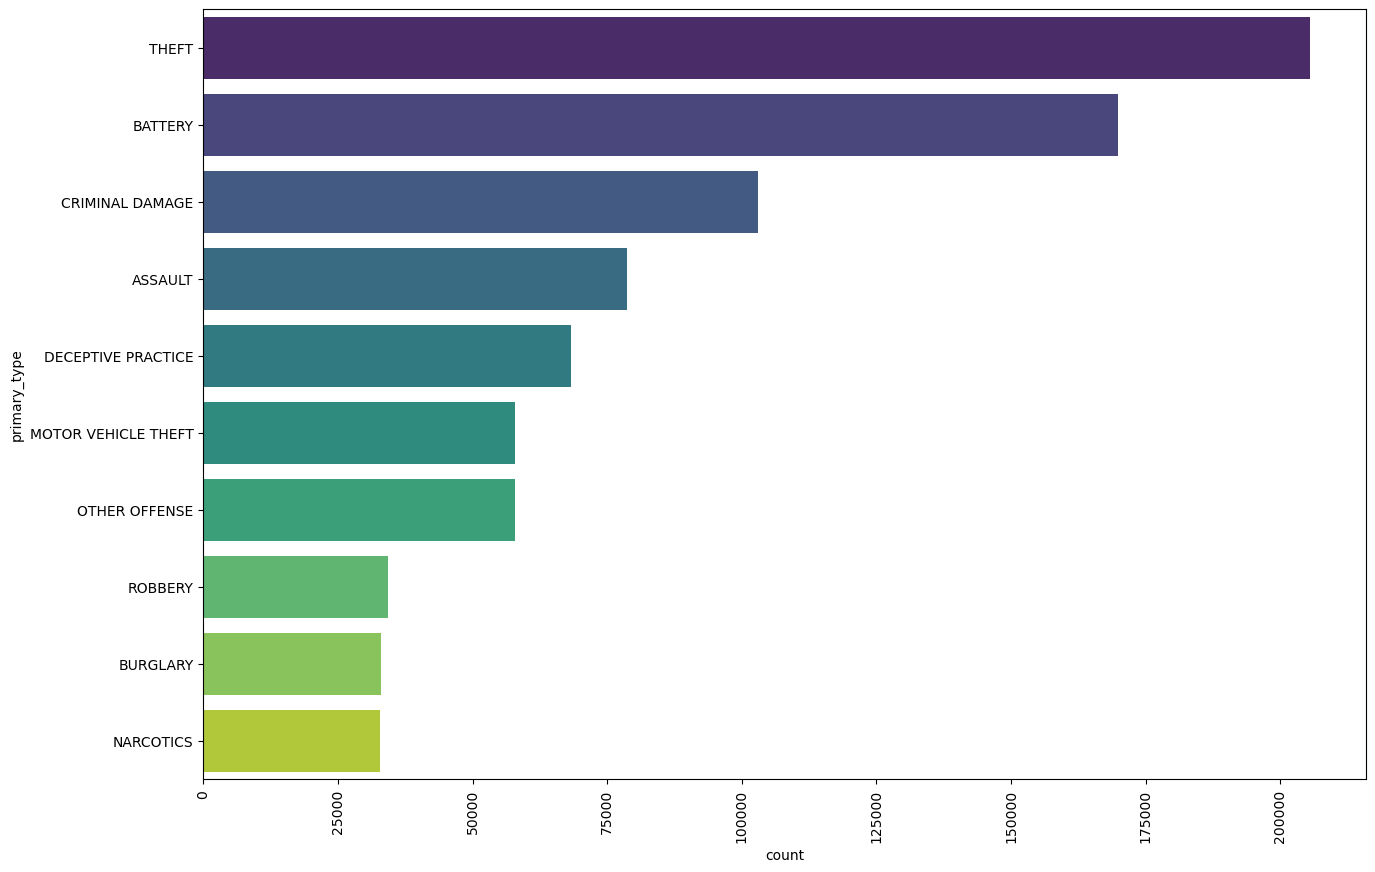

In [275]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'primary_type', data = df, palette='viridis', order = df['primary_type'].value_counts().index)
plt.xticks( rotation=90)
plt.show()

The most common type of crime appears to be theft, followed by battery and criminal damage. The least common types of crime reported are narcotics violations and burglary.

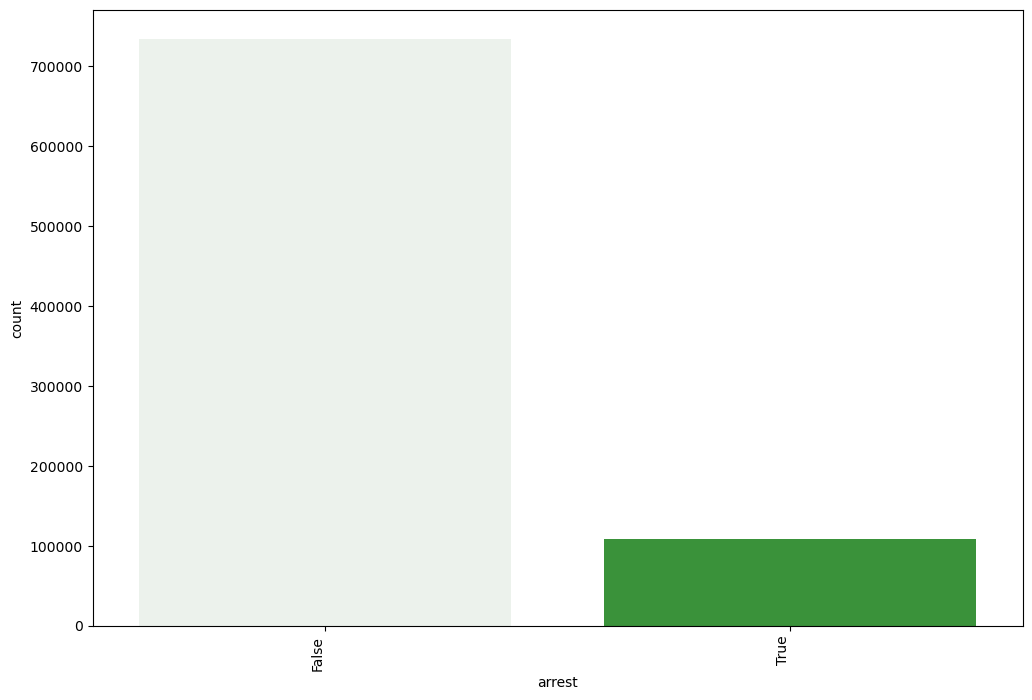

In [276]:
sns.countplot(x="arrest", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

The plot shows whether the arrest was made for a warrant or not. There were significantly less arrests made for outstanding warrants than there were for people who were not arrested . According to the y-axis, there were roughly 100,000 arrests made for warrants and close to 720,000 arrests of people who were not arrested.

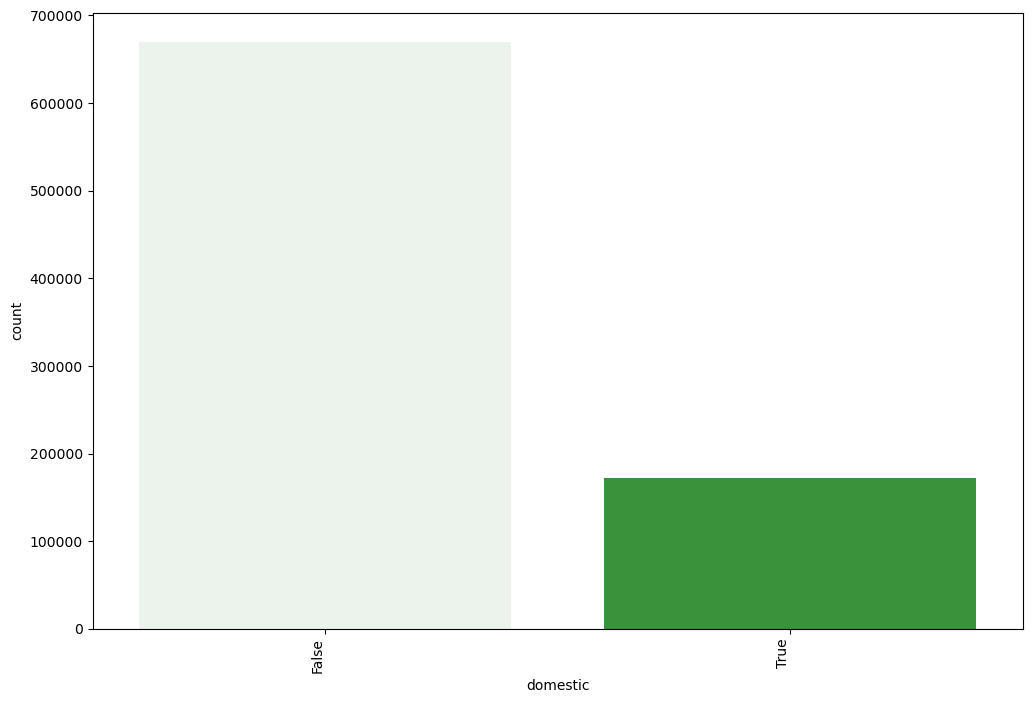

In [277]:
sns.countplot(x="domestic", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

The bar plot shows the number of crimes categorized as domestic or non-domestic. It appears that there were more non-domestic crimes than domestic crimes.

In [278]:
beats_series = df['beat'].value_counts()
top_10_beats = beats_series.nlargest(10)
top_10_beats

beat
1834    10123
421      7220
1831     6741
511      6429
624      6400
123      6188
111      6150
423      6025
631      6002
1112     5999
Name: count, dtype: int64

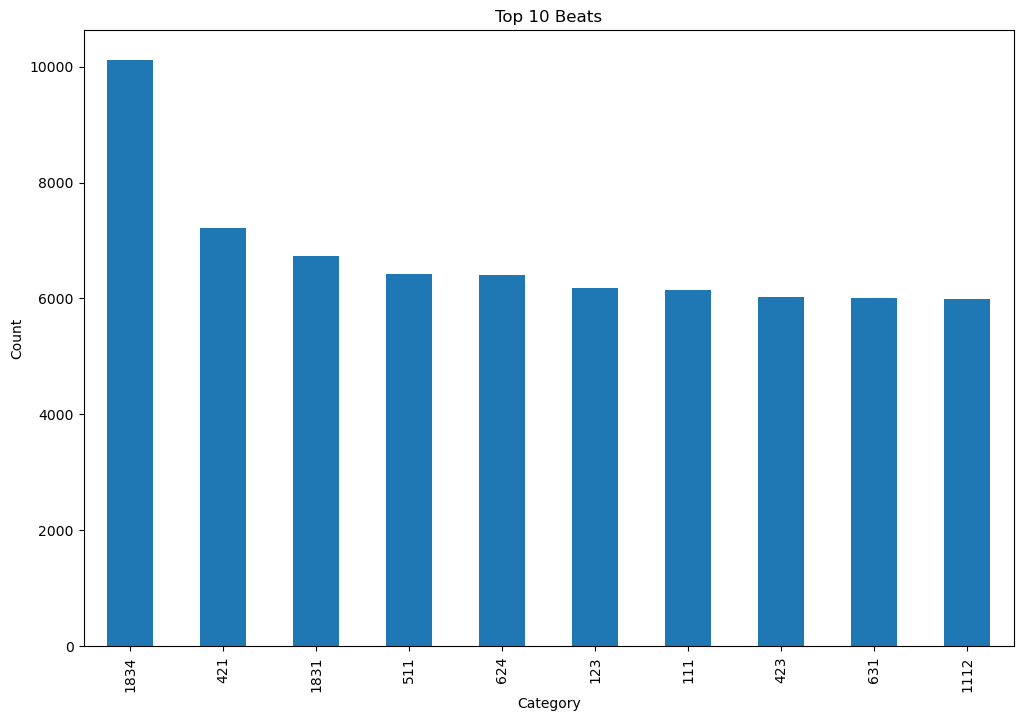

In [279]:
top_10_beats.plot(kind='bar')
plt.xlabel("Category") 
plt.ylabel("Count")   
plt.title("Top 10 Beats") 
plt.show()

The bar chart depicts the ten most frequent police beats, likely representing areas with a higher volume of police activity.
This chart reveals that Beat 1834 has the highest number of occurrences, followed by Beat 421 and Beat 1831. This suggests that law enforcement officers were dispatched to these areas more frequently than others. 

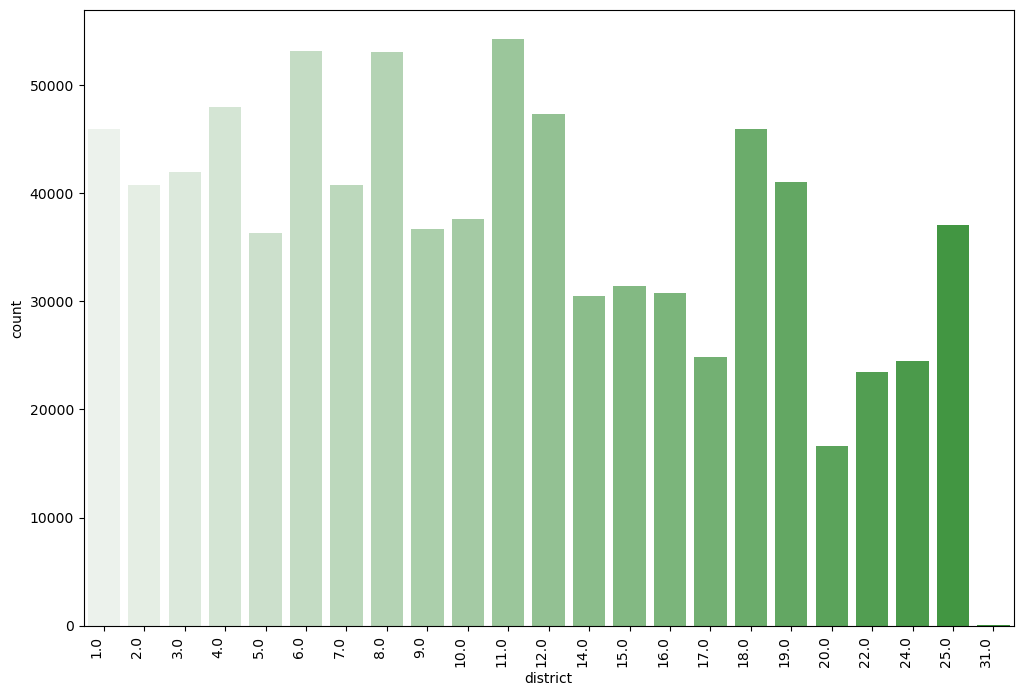

In [280]:
sns.countplot(x="district", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

This bar plot depicts the distribution of data points across different different police districts.  District 11 has the highest count, followed by District 8 and District 6.

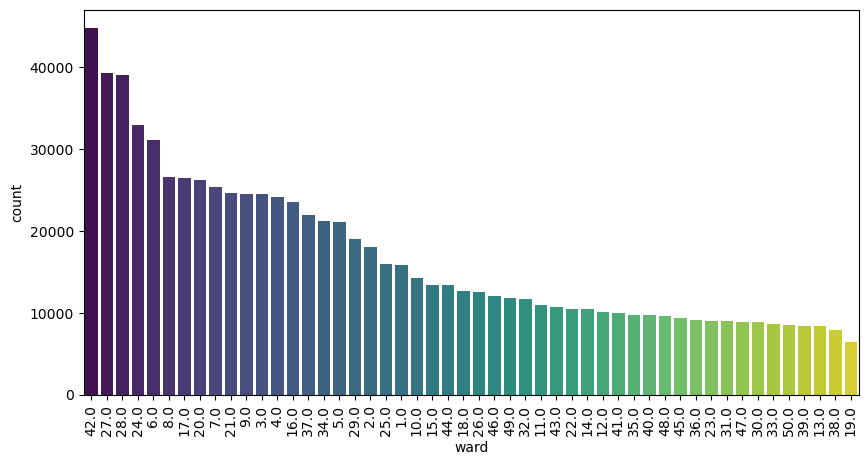

In [281]:
# Sort the community areas by count
sorted_areas = df['ward'].value_counts().index

# Create the countplot with sorted categories and wider figure
plt.figure(figsize=(10, 5))  # Adjust the figure size
sns.countplot(x="ward", data=df, order=sorted_areas, palette='viridis')
plt.xticks(rotation=90)
plt.show()


The plot shows the count distribution of the different police wards . Most of the crimes occur in the ward 42 followed by 28 and 27 . Least of the crimes occur in the ward 19.

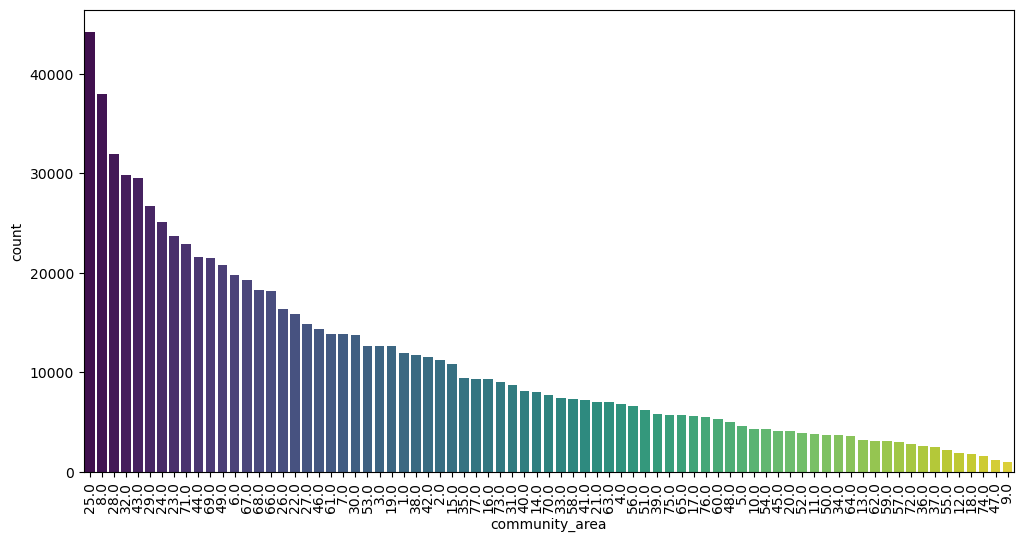

In [282]:
# Sort the community areas by count
sorted_areas = df['community_area'].value_counts().index

# Create the countplot with sorted categories and wider figure
plt.figure(figsize=(12, 6))  # Adjust the figure size
sns.countplot(x="community_area", data=df, order=sorted_areas, palette='viridis')
plt.xticks(rotation=90)
plt.show()

The graph shows the distribution of community area for different crimes . The most of the crimes occur in the community area 25 . It is followed by the community areas 8 and 28 . The least of the crime occurs in community area 9.

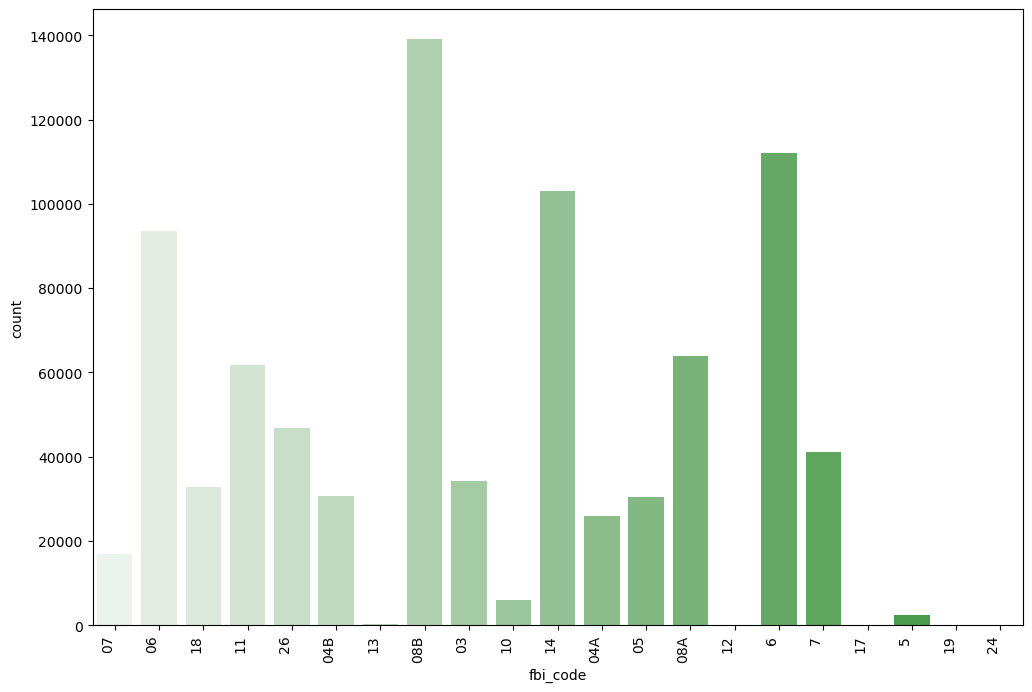

In [283]:
sns.countplot(x="fbi_code", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

The most crimes occur for FBI Code 08B followed by the FBI Code 6 . The least crimes occur for the FBI Codes 5 , 17 , 19 ,24.

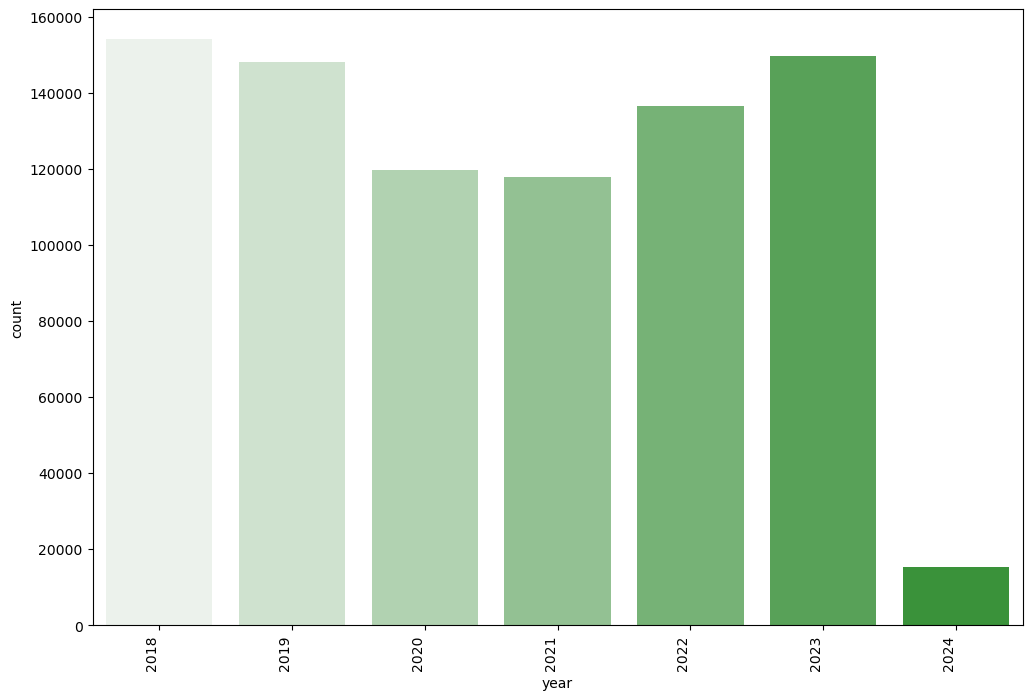

In [284]:
sns.countplot(x="year", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

This data suggests a trend of initially decreasing crime rates followed by a recent uptick. Here's a breakdown:

- 2018-2019 & 2019-2020: Crime rates saw a consistent decline, with a potentially larger decrease in the second year. This suggests a positive trend towards crime reduction.
- 2020-2021: The decrease in crime rates continued, though at a much slower pace compared to previous years. 
- 2021-2022 & 2022-2023: Both these years show a moderate increase in crime rates. This shift away from the downward trend warrants further investigation.

This data shows a promising decline in crime rates from 2018 to 2020, which could be linked to factors like reduced opportunity due to lockdowns during the COVID-19 pandemic. However, the slowdown in improvement in 2021 and the moderate increase in 2023 suggest a possible rebound as restrictions eased and social and economic disruptions from the pandemic unfolded.

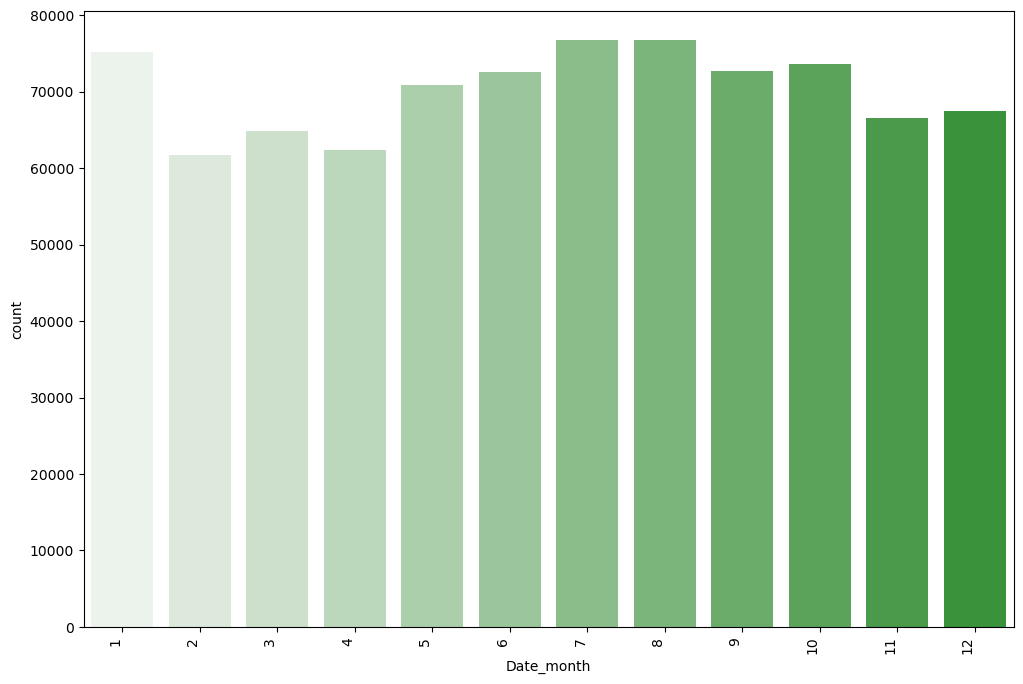

In [285]:
sns.countplot(x="Date_month", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

This graph depicts a possible seasonal pattern in crime rates over a year. Here's what we can observe:

Higher Crimes in Summer: The graph shows a potential peak in crime rates during the summer months (June, July, August). This could be due to a number of factors, such as warmer weather leading to more people being outdoors, or increased vacation times.
Lower Crimes in Winter: Conversely, the graph suggests crime rates might be lower in the winter months ( February , March). This could be because people tend to stay indoors more during colder weather.

Although we see high crime rates for the month January (This could be a reason because of New Years)

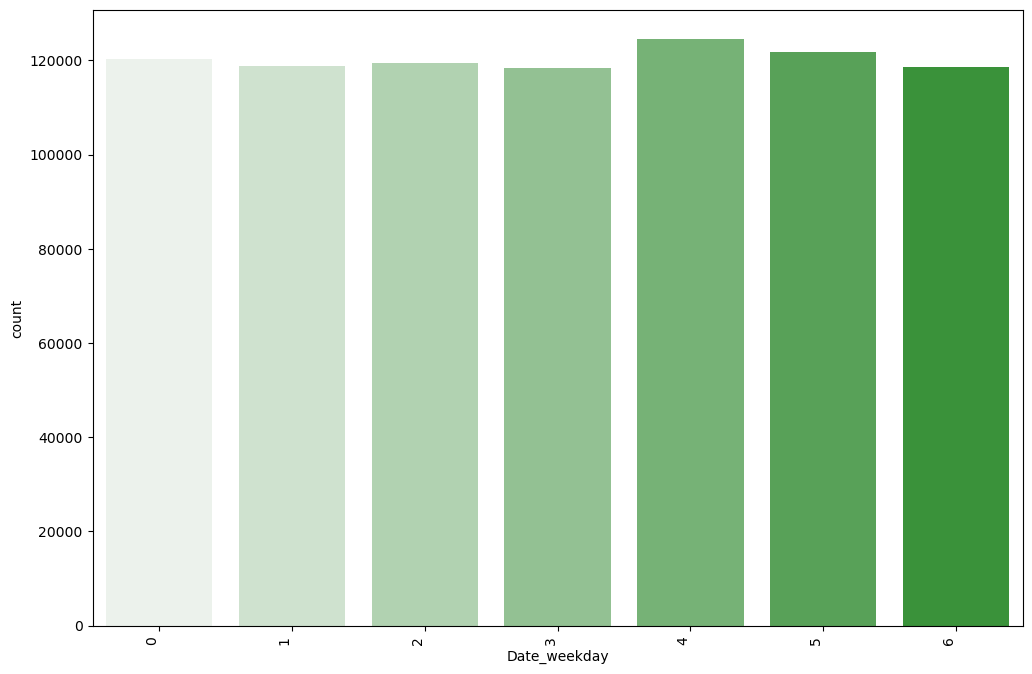

In [286]:
sns.countplot(x="Date_weekday", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

There are higher crimes occuring on weekends rather than weekdays.

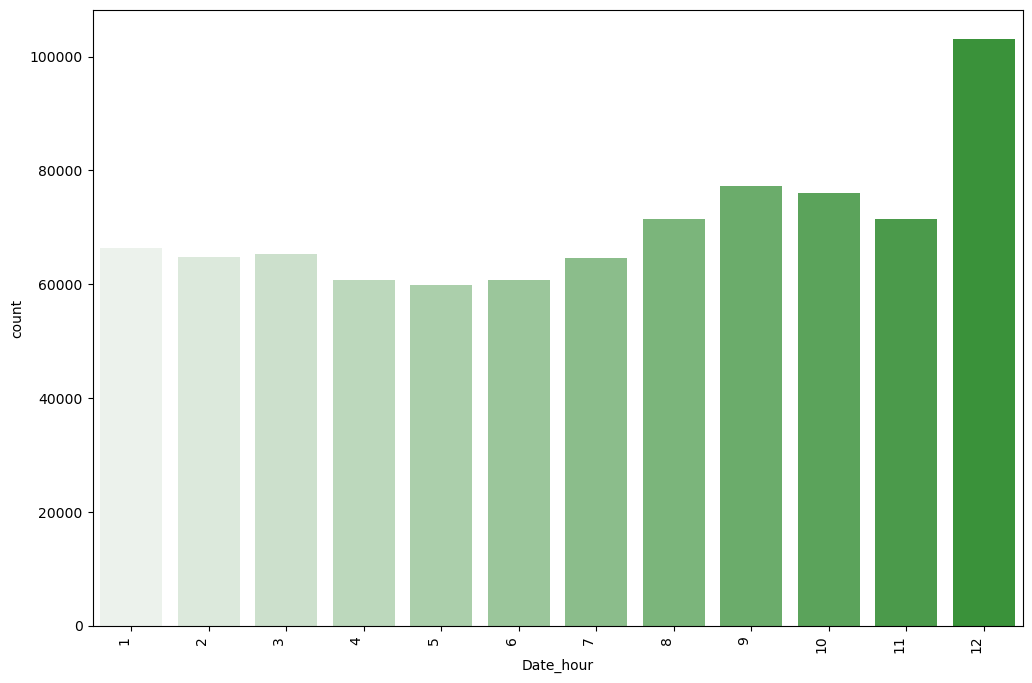

In [287]:
sns.countplot(x="Date_hour", data=df, palette='light:#2ca02c')
plt.xticks( rotation=90, ha='right')
plt.show()

As we can see there are high crime rates at the 12th hour .

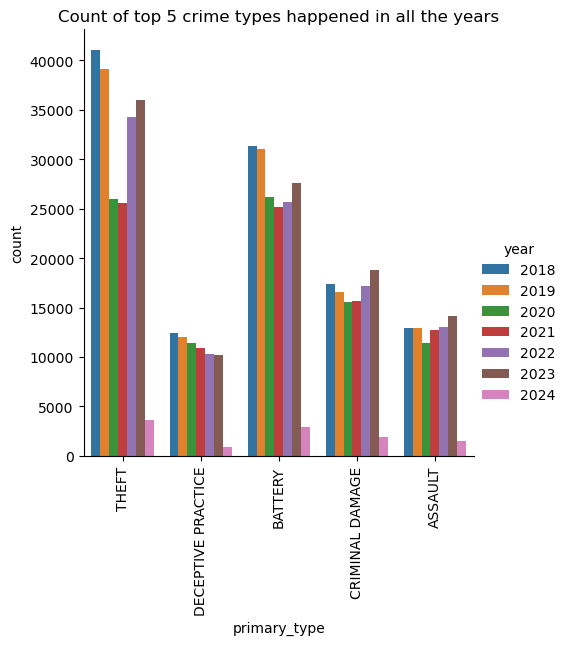

In [288]:
top_5_primary_types = df['primary_type'].value_counts().head(5).index

df_top_5 = df[df['primary_type'].isin(top_5_primary_types)]

sns.catplot(x='primary_type', hue='year', kind='count', data=df_top_5)
# plt.yscale('log')
plt.title('Count of top 5 crime types happened in all the years')
plt.xticks( rotation=90)
plt.show()

This catplot depicts trends in crime rates for various primary crime types across several years. Overall, theft appears to be the most common crime type across all the years, followed by deceptive practices, battery, criminal damage, and assault.

Deceptive practices seem to have potentially decreased over the years.
Battery rates might have seen a slight decrease followed by a increase in recent years. The same trend is followed by Theft , Criminal Damage and Assault

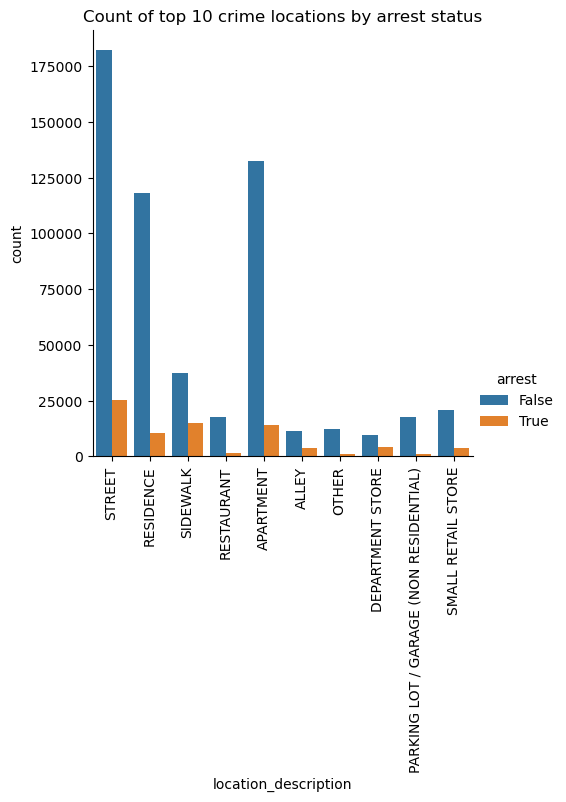

In [289]:
top_10_locations = df['location_description'].value_counts().head(10).index

df_top_10 = df[df['location_description'].isin(top_10_locations)]

sns.catplot(x='location_description', hue='arrest', kind='count', data=df_top_10)
# plt.yscale('log')
plt.title('Count of top 10 crime locations by arrest status')
plt.xticks( rotation=90)

plt.show()

Most Frequent Crimes: The locations with the highest overall crime counts are STREET, RESIDENCE, and APARTMENT.

Arrest Rates by Location: It appears that arrest rates vary depending on the location of the crime. For instance, a higher proportion of crimes might result in arrests for locations like DEPARTMENT STORE or SIDEWALK compared to places like RESIDENCE or STREET.

In [290]:
def fn_barplot(data, col):
    if data[col].dtype in ['object']:
        fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15, 20))
        
        plot_df = df[['arrest', col]].dropna()
        df_1 = plot_df.loc[plot_df['arrest']==True]
        df_2 = plot_df.loc[plot_df['arrest']==False]
        
        df_1.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=ax1, title='Arrest: ' + col)
        df_2.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=ax2, title='No Arrest: ' + col)
        
        plt.show()

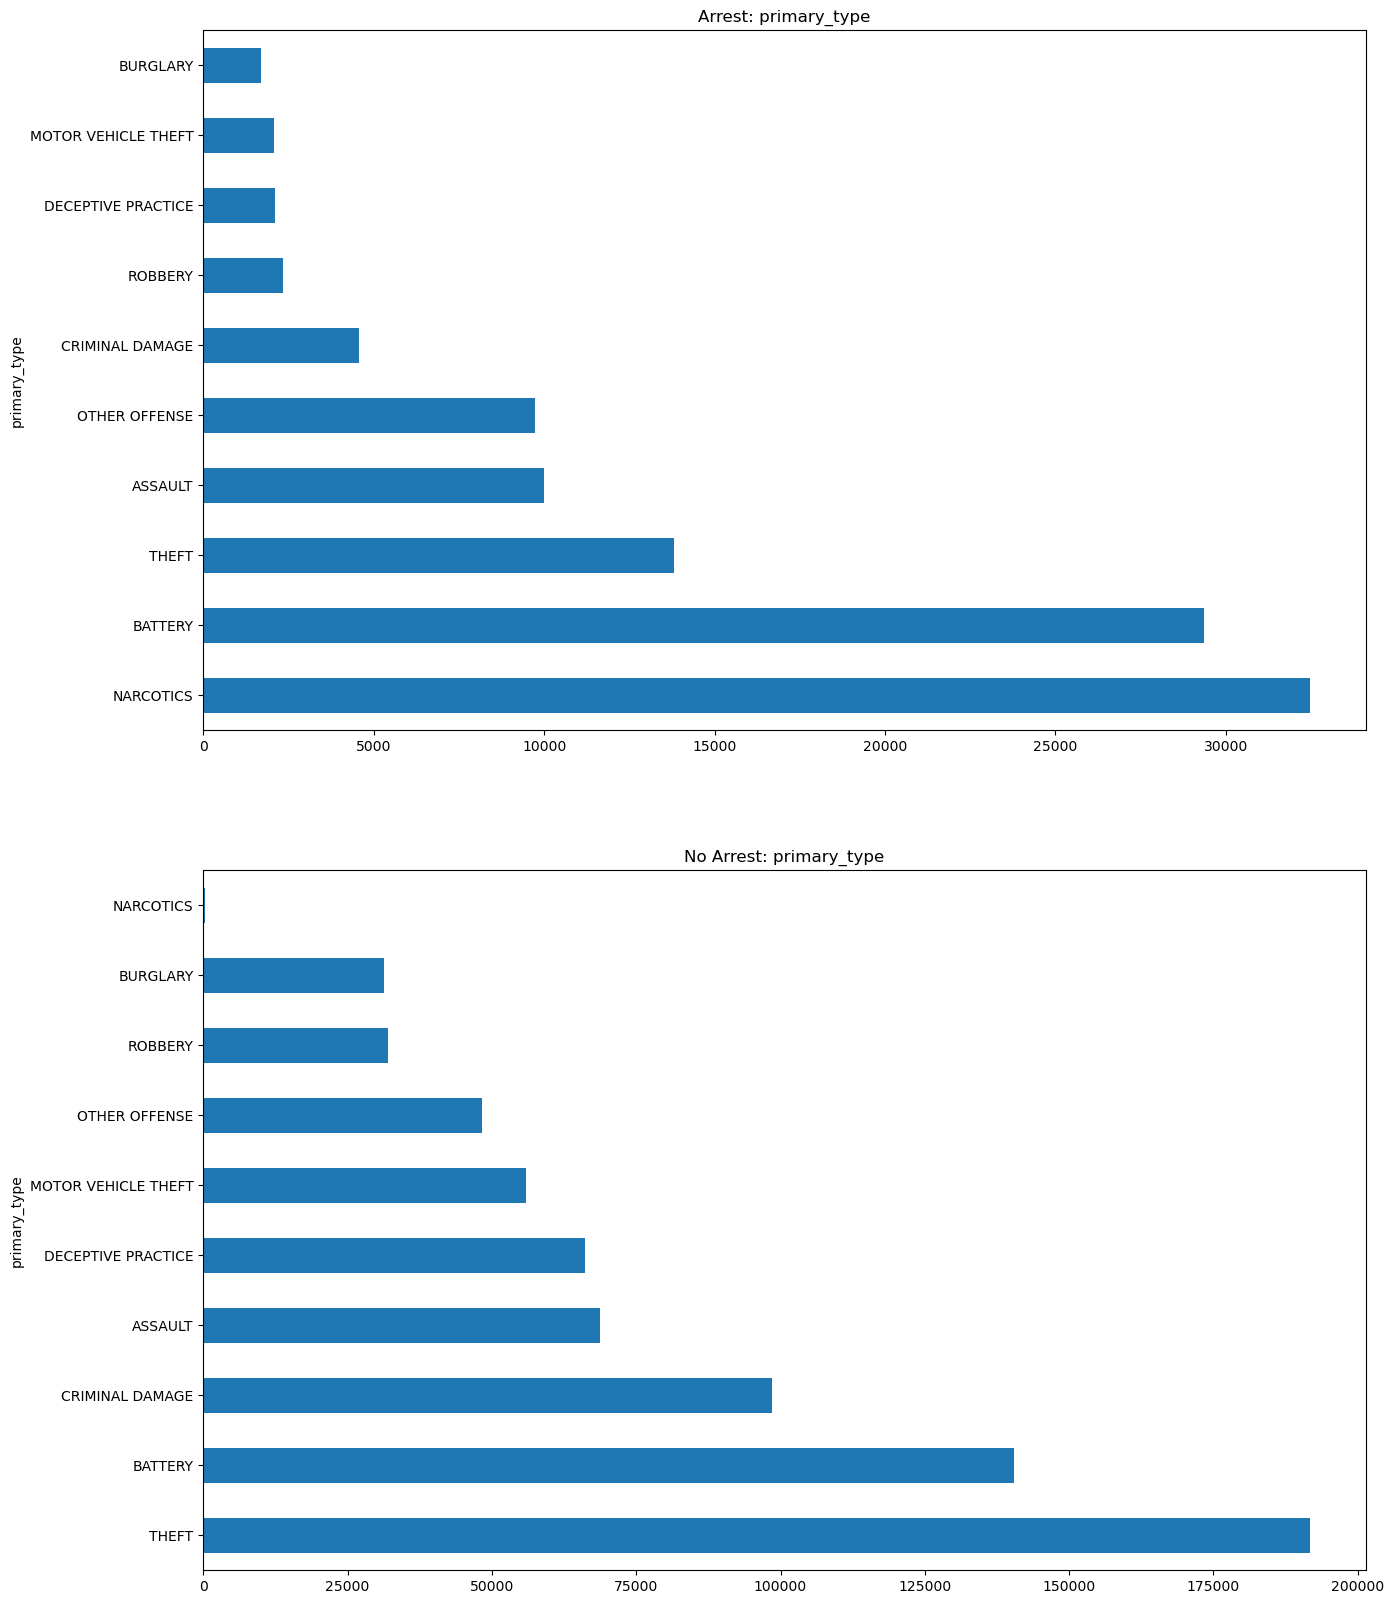

In [291]:
fn_barplot(df, 'primary_type')

Most arrests were made for Narcotics and Battery. However, the graphs reveal that arrests were less common for theft, battery and criminal damage cases.

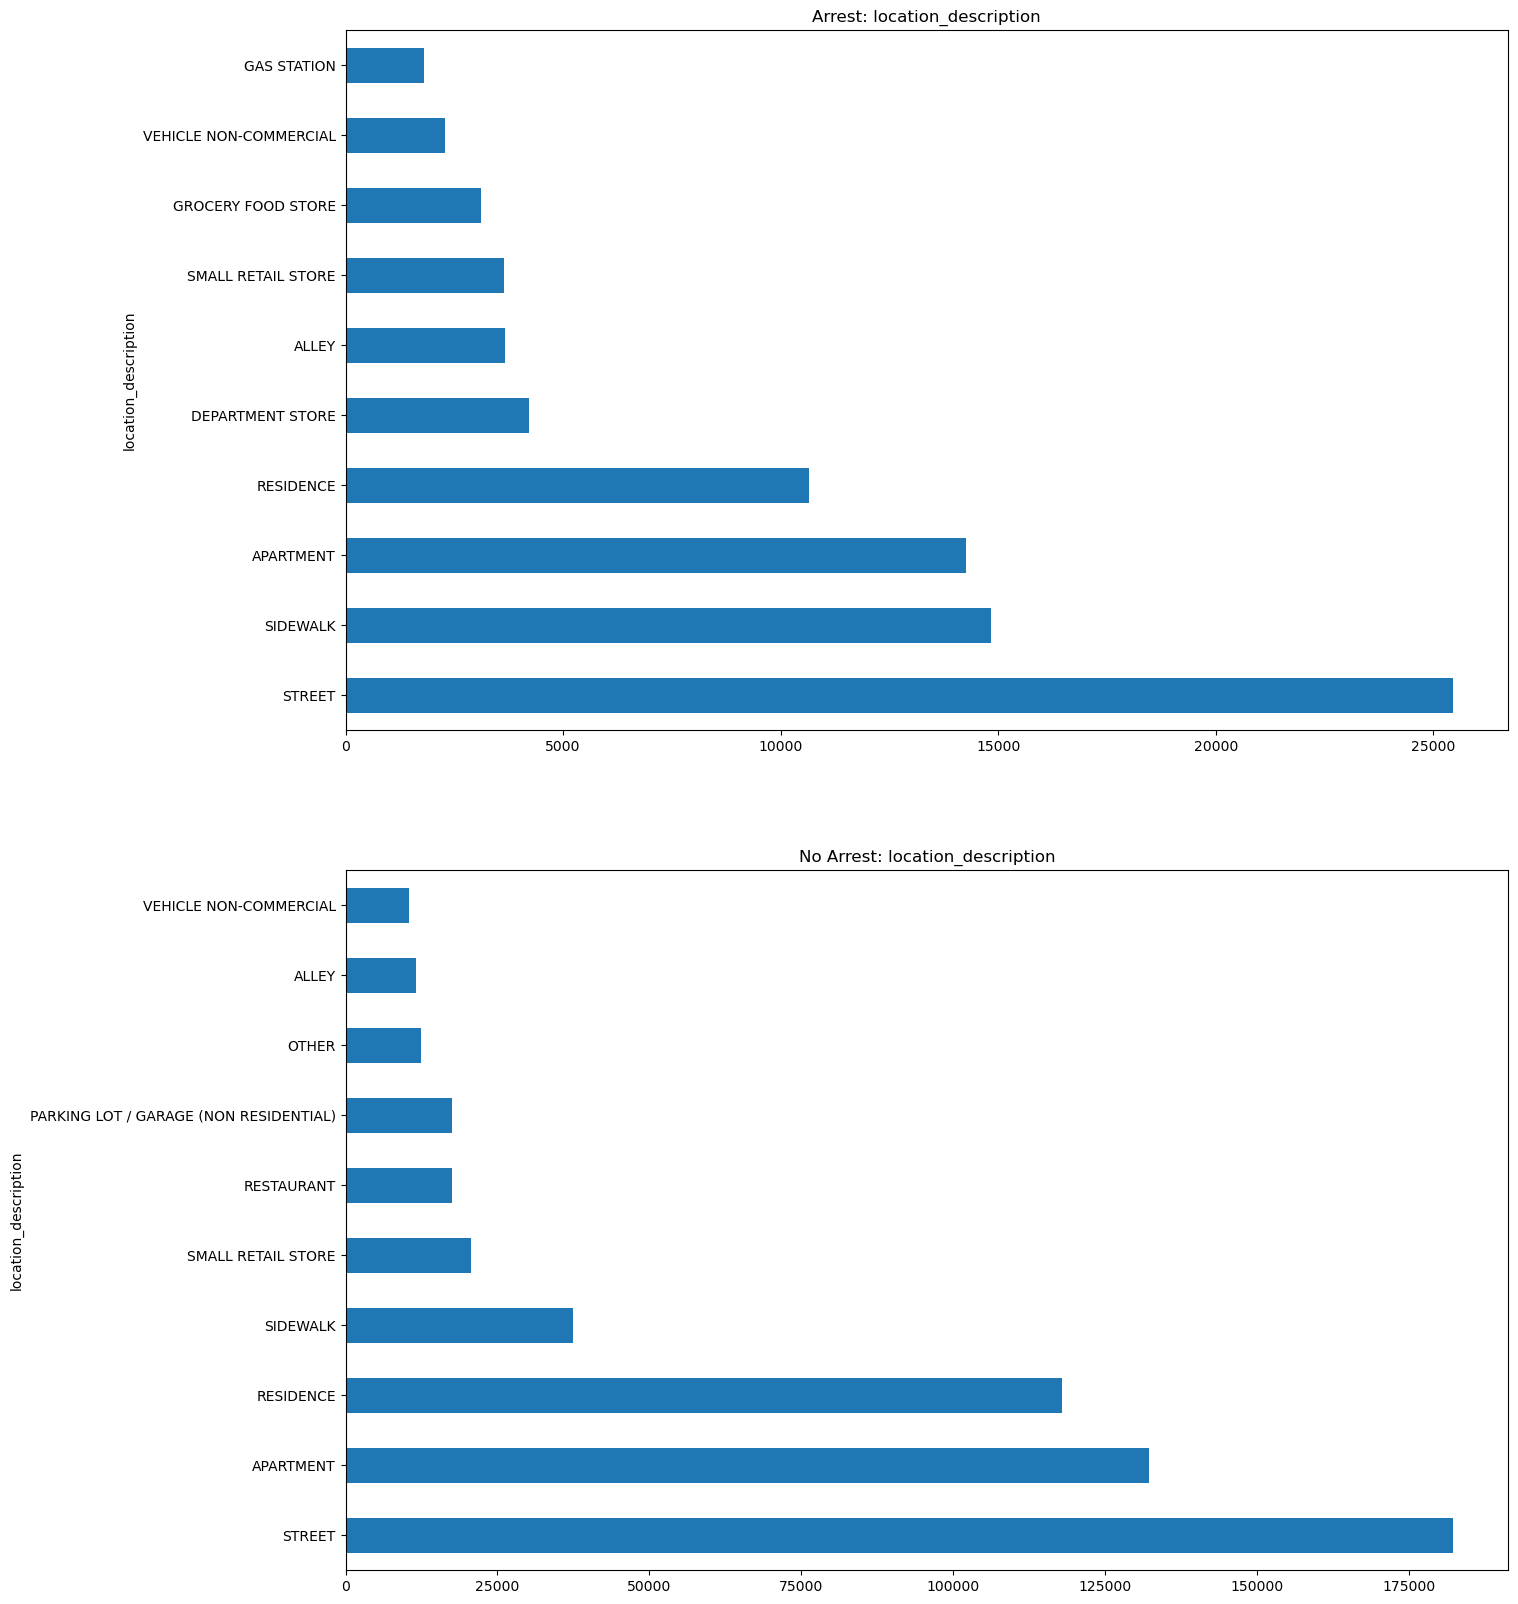

In [292]:
fn_barplot(df, 'location_description')

As we can observe that the highest count of location which results in an arrest is Street  and Sidewalk. Also top locations that did not result in arrests were Street , Apartment and Residence.


Contingency Table (with percentages):
arrest        False      True 
domestic                      
False     79.973687  76.657482
True      20.026313  23.342518

Chi-square test:
Chi-square statistic: 636.8725890411037
p-value: 1.59995944236914e-140


<Axes: xlabel='domestic'>

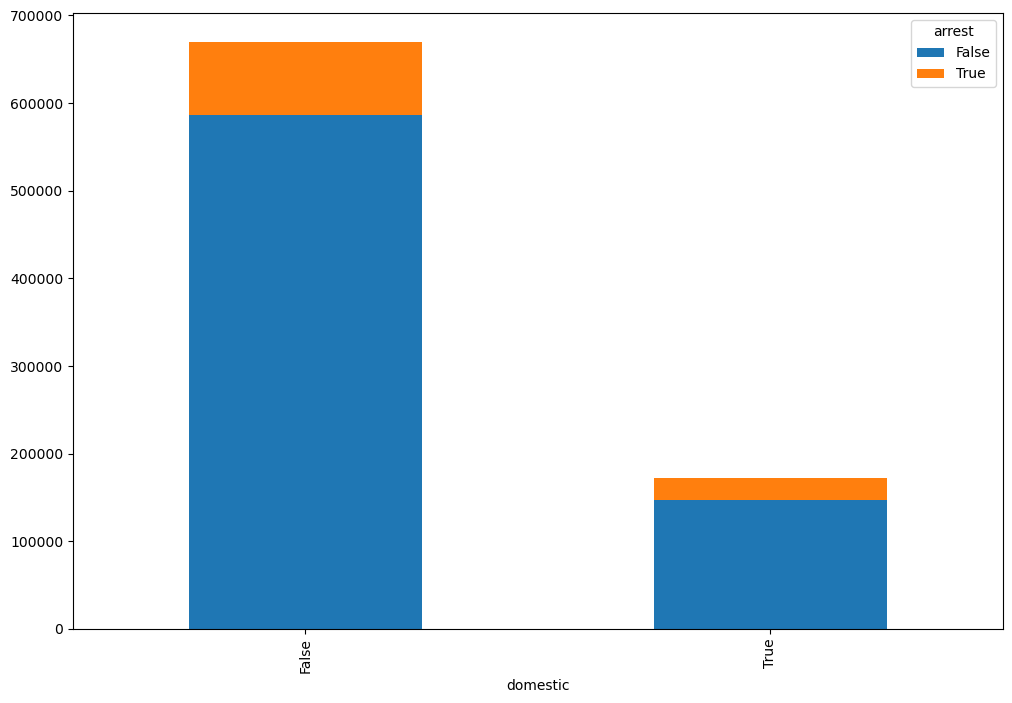

In [293]:
from scipy.stats import chi2_contingency
# Contingency table (Cross-tabulation)
contingency_table = pd.crosstab(df['domestic'], df['arrest'])

# Calculate row and column totals
row_totals = contingency_table.sum(axis=1)
col_totals = contingency_table.sum(axis=0)

# Calculate percentages
percentages = (contingency_table / np.sum(contingency_table)) * 100

# print("Contingency Table:")
# print(contingency_table)
print("\nContingency Table (with percentages):")
print(percentages)

# Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-square test:")
print("Chi-square statistic:", chi2)
print("p-value:", p)

# You can also visualize the data using a bar plot
contingency_table.plot(kind='bar', stacked=True)

From above graph, we can say that there is a significant association between the variables arrest and domestic, as indicated by both the chi-square statistic and the very low p-value.

In [294]:
import folium

In [295]:
Chicago_CoOrdinates = [41.881832, -87.623177]
chicago_map = folium.Map(location=Chicago_CoOrdinates, zoom_start=10)

In [296]:
def fn_crime_map(crime_type):
    Crimes = df[df["primary_type"] == crime_type]
    locations = Crimes.groupby('community_area').first()
    new_locations = locations.loc[:, ['latitude', 'longitude', 'location_description', 'arrest','block' ]]
    
    for i in range(len(new_locations)):
        lat = new_locations.iloc[i][0]
        long = new_locations.iloc [i][1]
        popup_text = """community_index : {}<br>
                    arrest : {}<br>
                    location : {}<br>
                    block : {}<br>
                    """
        popup_text = popup_text.format(new_locations.index[i],
                                new_locations.iloc[i][-2], 
                                new_locations.iloc [i][-3],
                                new_locations.iloc [i][4]
                                )       
        folium.CircleMarker(location = [lat, long], popup= popup_text, fill = True).add_to(chicago_map)
        
    return chicago_map

In [297]:
def fn_crime_map(crime_types):
    chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11)  # Initialize map
    color_map = {
        'THEFT': 'blue',
        'BATTERY': 'red',
        'CRIMINAL DAMAGE': 'green'
        
    }
    for crime_type in crime_types:
        Crimes = df[df["primary_type"] == crime_type]
        locations = Crimes.groupby('community_area').first()
        new_locations = locations.loc[:, ['latitude', 'longitude', 'location_description', 'arrest', 'block']]
        
        for i in range(len(new_locations)):
            lat = new_locations.iloc[i][0]
            long = new_locations.iloc[i][1]
            popup_text = """community_index : {}<br>
                            arrest : {}<br>
                            location : {}<br>
                            block : {}<br>
                            """
            popup_text = popup_text.format(new_locations.index[i],
                                            new_locations.iloc[i][-2],
                                            new_locations.iloc[i][-3],
                                            new_locations.iloc[i][4]
                                           )   
            color = color_map.get(crime_type, 'gray')
            folium.CircleMarker(location=[lat, long], popup=popup_text, fill=True, color=color, fill_color=color).add_to(chicago_map)
    
    return chicago_map



In [298]:
from collections import Counter

def fn_crime_map3(crime_types):
  chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)  # Initialize map

  color_map = {
      'THEFT': 'blue',
      'BATTERY': 'red',
      'CRIMINAL DAMAGE': 'green',
      
  }

  arrest_list = []  # List to store location_descriptions for arrests
  arrest_location_counts = {}  # Dictionary to store arrest location counts

  for crime_type in crime_types:
    Crimes = df[df["primary_type"] == crime_type]
    locations = Crimes.groupby('community_area').first()
    new_locations = locations.loc[:, ['latitude', 'longitude', 'location_description', 'arrest', 'block']]

    for i in range(len(new_locations)):
      if new_locations.iloc[i][3]:  # Check if arrest is True
        lat = new_locations.iloc[i][0]
        long = new_locations.iloc[i][1]
        location_description = new_locations.iloc[i][2]
        arrest_list.append(location_description)

        # Update arrest location counts
        arrest_location_counts[location_description] = arrest_location_counts.get(location_description, 0) + 1

        popup_text = """community_index : {}<br>
                       arrest : {}<br>
                       location : {}<br>
                       block : {}<br>
                       """.format(new_locations.index[i],
                                 new_locations.iloc[i][-2],
                                 location_description,
                                 new_locations.iloc[i][4])
        color = color_map.get(crime_type, 'gray')
        folium.CircleMarker(location=[lat, long], popup=popup_text, fill=True, color=color, fill_color=color).add_to(chicago_map)

  # Find most frequent arrest locations
  most_frequent_arrests = Counter(arrest_location_counts).most_common(10)  # Adjust limit as needed

  return chicago_map 

In [299]:

crime_types_to_plot = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE']
fn_crime_map3(crime_types_to_plot)

The most common locations for arrests, categorized by specific crimes such as theft, battery, and criminal damage, include apartments, streets, alleys, sidewalks, CTA trains, residences, CTA platforms, department stores, CTA buses, and gas stations.

In [300]:
from collections import Counter

def fn_crime_map4(crime_types):
  chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)  # Initialize map

  color_map = {
      'THEFT': 'blue',
      'BATTERY': 'red',
      'CRIMINAL DAMAGE': 'green',
     
  }

  domestic_list = []  # List to store location_descriptions for arrests
  domestic_location_counts = {}  # Dictionary to store arrest location counts

  for crime_type in crime_types:
    Crimes = df[df["primary_type"] == crime_type]
    locations = Crimes.groupby('community_area').first()
    new_locations = locations.loc[:, ['latitude', 'longitude', 'location_description', 'arrest', 'block','domestic']]

    for i in range(len(new_locations)):
      if new_locations.iloc[i][5]:  # Check if arrest is True
        lat = new_locations.iloc[i][0]
        long = new_locations.iloc[i][1]
        location_description = new_locations.iloc[i][2]
        domestic_list.append(location_description)

        # Update arrest location counts 
        domestic_location_counts[location_description] = domestic_location_counts.get(location_description, 0) + 1

        popup_text = """community_index : {}<br>
                       arrest : {}<br>
                       location : {}<br>
                       block : {}<br>
                       """.format(new_locations.index[i],
                                 new_locations.iloc[i][-2],
                                 location_description,
                                 new_locations.iloc[i][4])
        color = color_map.get(crime_type, 'gray')
        folium.CircleMarker(location=[lat, long], popup=popup_text, fill=True, color=color, fill_color=color).add_to(chicago_map)

  # Find most frequent arrest locations 
  most_frequent_domestic = Counter(domestic_location_counts).most_common(10)

  return chicago_map  

In [301]:

crime_types_to_plot = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE']
fn_crime_map4(crime_types_to_plot)

The top locations for domestic crimes across specific crime types include apartments, residences, streets, alleys, and various other areas such as non-commercial vehicles, gas stations, and public school buildings.

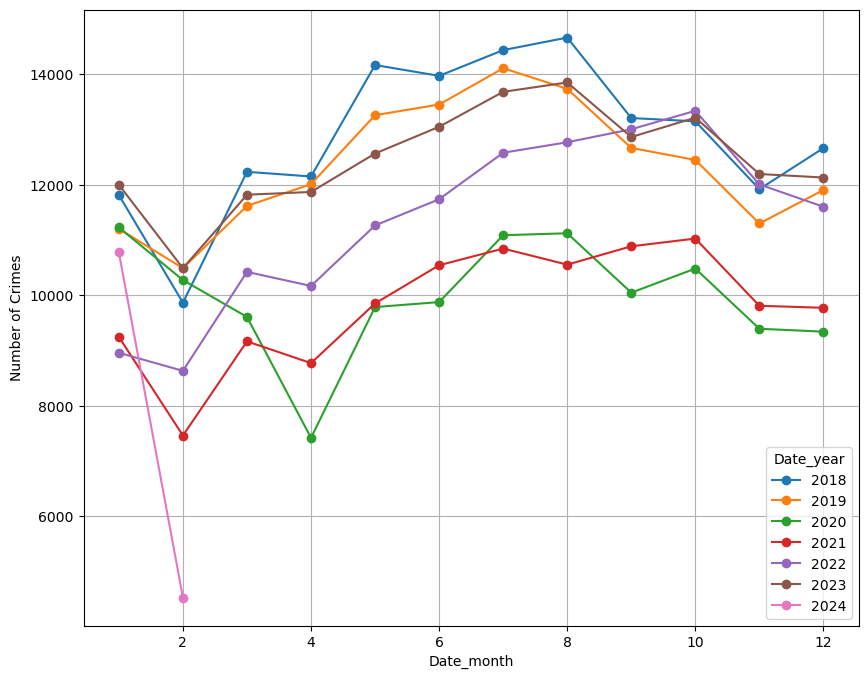

In [302]:
df.groupby(['Date_month','Date_year'])['unique_key'].count().unstack().plot(marker='o',figsize=(10,8))
plt.ylabel('Number of Crimes')
plt.grid()
plt.show()

General Trend (2018 - 2023):
These years exhibit a pattern of fluctuation across months, with potential seasonal variations.
Certain months, like summer (June-August), might see higher crime rates due to increased social activity.

2020: 
This year displays a clear decrease in crime rates, particularly in the earlier months.
This significant drop likely coincides with lockdown measures implemented during the COVID-19 pandemic.


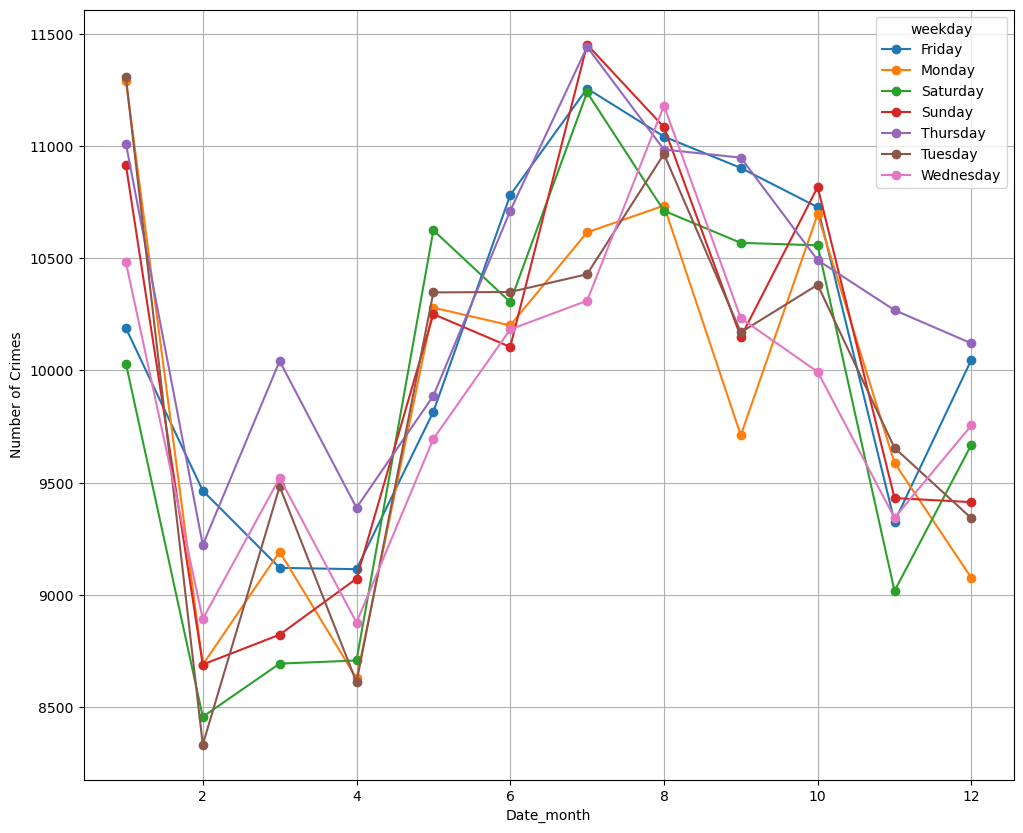

In [303]:
dayOfWeek={1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'}
df['weekday'] = df['Date_weekday'].map(dayOfWeek)

df.groupby(['Date_month','weekday'])['unique_key'].count().unstack().plot(marker='o',figsize=(12,10))
plt.ylabel('Number of Crimes')
plt.grid()
plt.show()

The crime data shows a potential weekend spike, with Thursdays and Fridays seeing higher numbers. This could be due to a combination of factors. More people might be out socializing, leading to increased opportunity for crimes. Businesses with weekend staff reductions could be easier targets. Finally, some reported crimes might be incidents that happened earlier but weren't reported until the weekend.

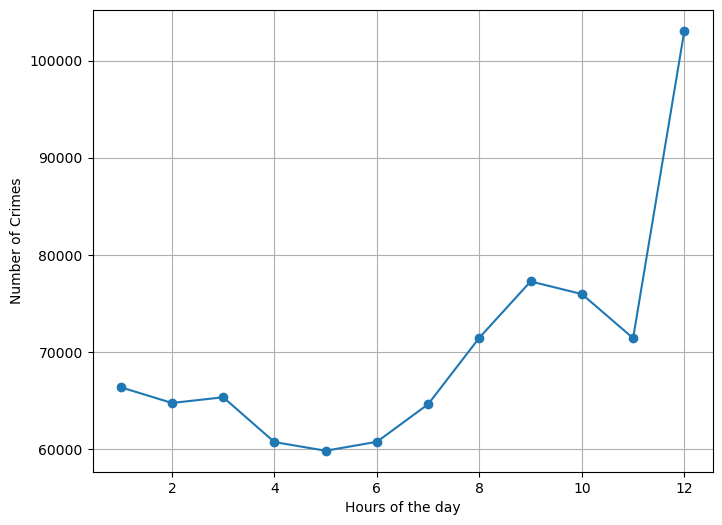

In [304]:
df.groupby(['Date_hour'])['unique_key'].count().plot(marker='o',figsize=(8,6))
plt.ylabel('Number of Crimes')
plt.xlabel('Hours of the day')
plt.grid()
plt.show()

Again as we can observe most of the crimes occur at 12th hour.

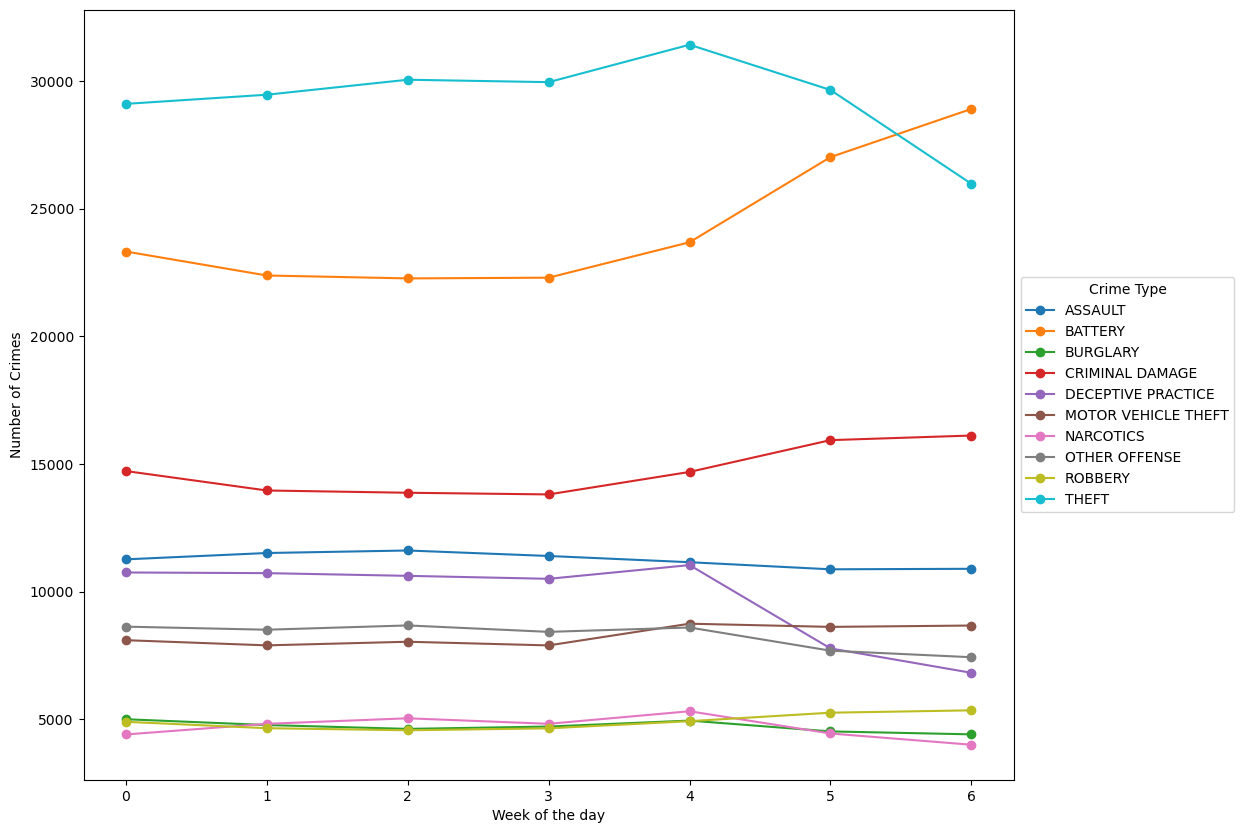

In [306]:
# Group by 'Date_hour' and 'primary_type', count 'unique_key', and unstack
grouped_data1 = df.groupby(['Date_weekday', 'primary_type'])['unique_key'].count().unstack()

# Plot the data
ax = grouped_data1.plot(marker='o', figsize=(12, 10))

plt.ylabel('Number of Crimes')
plt.xlabel('Week of the day')

# Create a separate legend outside the plot
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, title='Crime Type', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

There is general trend for Narcotics , Robbery , Burglary , Motor Vehicle Theft , Other Offense . Although For Battery the crimes increase in the weekend . Same for criminal damage.

In [334]:
crime_frequency = df.groupby(["district", "primary_type"]).count()
top_5_districts = crime_frequency['unique_key'].sort_values( ascending=False).head(5)
top_5_districts

district  primary_type
18.0      THEFT           20603
1.0       THEFT           19946
19.0      THEFT           16079
12.0      THEFT           15529
11.0      BATTERY         12519
Name: unique_key, dtype: int64

### Multivarite Analysis

In [53]:
cols = ['primary_type', 'location_description', 'arrest', 'year', 'district']

In [54]:
df_selected = df[cols]

In [56]:
df

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,latitude,longitude,location,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday
0,12574617,JE485673,2021-12-22 06:00:00+00:00,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,...,41.776110,-87.603399,"(41.77610957, -87.60339913)",2021,12,22,6,0,2,Tuesday
1,11353790,JB314783,2018-06-19 11:00:00+00:00,069XX S OGLESBY AVE,0895,THEFT,FROM COIN-OP MACHINE/DEVICE,RESIDENCE,False,False,...,41.769168,-87.568224,"(41.769168164, -87.568224317)",2018,6,19,11,0,1,Monday
2,11429478,JB383883,2018-08-07 08:05:00+00:00,0000X E 102ND PL,2014,NARCOTICS,MANUFACTURE / DELIVER - HEROIN (WHITE),SIDEWALK,True,False,...,NaN,NaN,NaN,2018,8,7,8,5,1,Monday
4,11976669,JD146049,2020-02-09 06:20:00+00:00,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,RESTAURANT,True,False,...,41.888073,-87.625384,"(41.888073217, -87.625384145)",2020,2,9,6,20,6,Saturday
6,11322607,JB273333,2018-05-22 02:15:00+00:00,065XX S INGLESIDE AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,APARTMENT,False,True,...,41.776159,-87.602185,"(41.77615948, -87.602185069)",2018,5,22,2,15,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,12550076,JE456290,2021-11-24 08:50:00+00:00,088XX S BURLEY AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,...,41.735034,-87.545782,"(41.735033879, -87.545782092)",2021,11,24,8,50,2,Tuesday
926745,11875493,JC490185,2019-10-28 12:00:00+00:00,027XX W 59TH ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,...,41.786437,-87.691742,"(41.786436773, -87.691742061)",2019,10,28,12,0,0,Sunday
926746,12667273,JF203895,2022-03-30 04:00:00+00:00,023XX W WARREN BLVD,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,...,41.882104,-87.684752,"(41.882103874, -87.684752469)",2022,3,30,4,0,2,Tuesday
926747,12250481,JD464637,2020-12-19 10:00:00+00:00,040XX W HARRISON ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,...,41.873434,-87.726709,"(41.873433563, -87.726708664)",2020,12,19,10,0,5,Friday


In [57]:
df.columns

Index(['unique_key', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location', 'Date_year', 'Date_month', 'Date_day', 'Date_hour',
       'Date_minute', 'Date_weekday', 'weekday'],
      dtype='object')

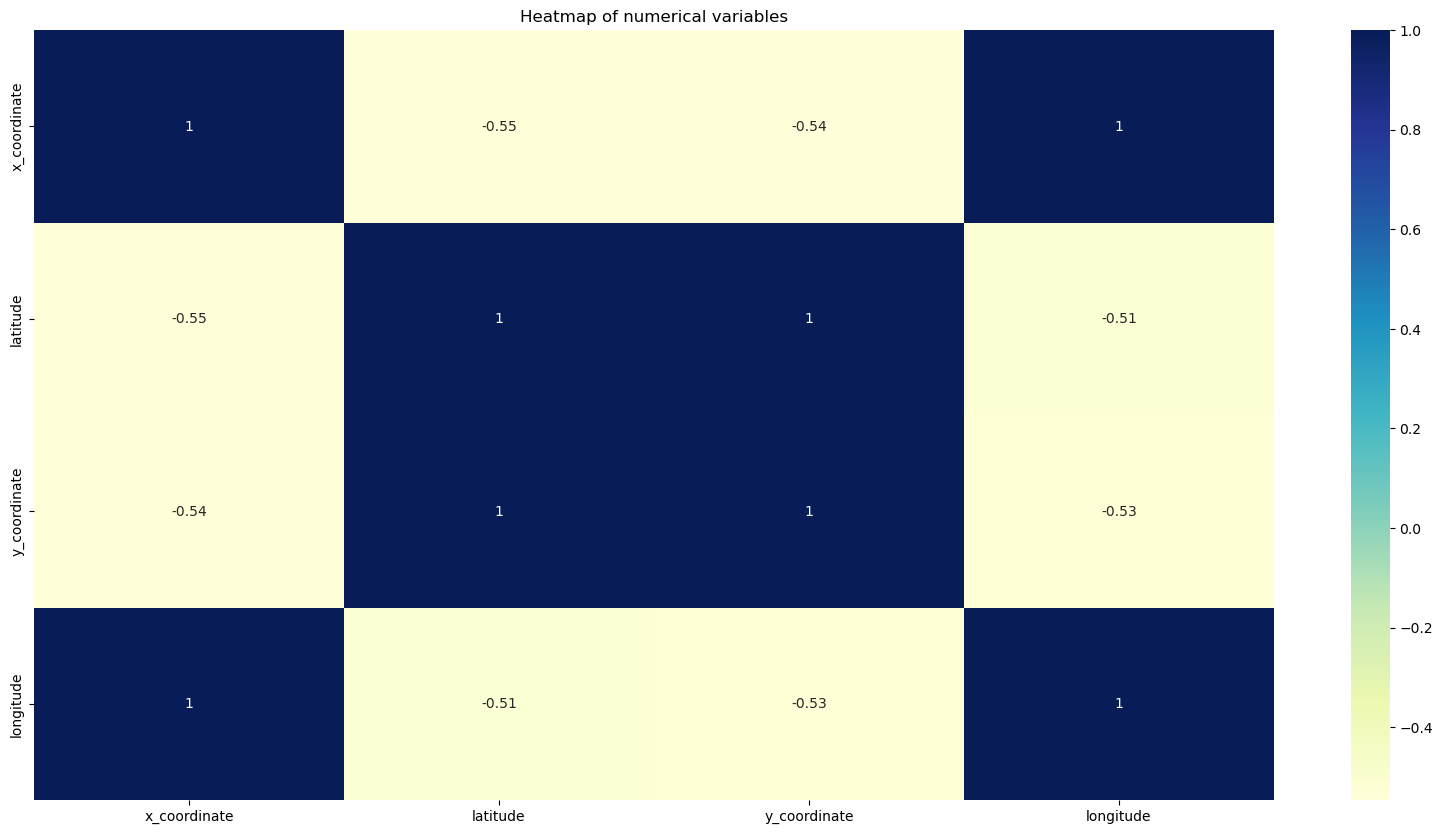

In [58]:
numeric_features = ['x_coordinate','latitude','y_coordinate','longitude']
co = df[numeric_features]
plt.figure(figsize=(20, 10))
sns.heatmap(co.corr(), annot = True, cmap="YlGnBu")
plt.title('Heatmap of numerical variables')
plt.show()

## Data Preparation

#### The columns that dont have much significance 

In [59]:
columns_to_drop = ['unique_key', 'case_number', 'updated_on', 'x_coordinate', 'y_coordinate','location']
df.drop(columns=columns_to_drop, inplace=True)
df

,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,...,year,latitude,longitude,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday
0,2021-12-22 06:00:00+00:00,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,321,3.0,...,2021,41.776110,-87.603399,2021,12,22,6,0,2,Tuesday
1,2018-06-19 11:00:00+00:00,069XX S OGLESBY AVE,0895,THEFT,FROM COIN-OP MACHINE/DEVICE,RESIDENCE,False,False,331,3.0,...,2018,41.769168,-87.568224,2018,6,19,11,0,1,Monday
2,2018-08-07 08:05:00+00:00,0000X E 102ND PL,2014,NARCOTICS,MANUFACTURE / DELIVER - HEROIN (WHITE),SIDEWALK,True,False,511,5.0,...,2018,NaN,NaN,2018,8,7,8,5,1,Monday
4,2020-02-09 06:20:00+00:00,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,THEFT OF LABOR/SERVICES,RESTAURANT,True,False,111,1.0,...,2020,41.888073,-87.625384,2020,2,9,6,20,6,Saturday
6,2018-05-22 02:15:00+00:00,065XX S INGLESIDE AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,APARTMENT,False,True,321,3.0,...,2018,41.776159,-87.602185,2018,5,22,2,15,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,2021-11-24 08:50:00+00:00,088XX S BURLEY AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,424,4.0,...,2021,41.735034,-87.545782,2021,11,24,8,50,2,Tuesday
926745,2019-10-28 12:00:00+00:00,027XX W 59TH ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,824,8.0,...,2019,41.786437,-87.691742,2019,10,28,12,0,0,Sunday
926746,2022-03-30 04:00:00+00:00,023XX W WARREN BLVD,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,...,2022,41.882104,-87.684752,2022,3,30,4,0,2,Tuesday
926747,2020-12-19 10:00:00+00:00,040XX W HARRISON ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,1132,11.0,...,2020,41.873434,-87.726709,2020,12,19,10,0,5,Friday


In [60]:
df.columns

Index(['date', 'block', 'iucr', 'primary_type', 'description',
       'location_description', 'arrest', 'domestic', 'beat', 'district',
       'ward', 'community_area', 'fbi_code', 'year', 'latitude', 'longitude',
       'Date_year', 'Date_month', 'Date_day', 'Date_hour', 'Date_minute',
       'Date_weekday', 'weekday'],
      dtype='object')

#### We should not include description and fbi_code too  because it already kind if conveys the type of crime. This can result in data leakage .

In [61]:
df.drop(columns=['description','fbi_code'], inplace=True)
df

,date,block,iucr,primary_type,location_description,arrest,domestic,beat,district,ward,...,year,latitude,longitude,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday
0,2021-12-22 06:00:00+00:00,065XX S DREXEL AVE,0930,MOTOR VEHICLE THEFT,STREET,False,False,321,3.0,20.0,...,2021,41.776110,-87.603399,2021,12,22,6,0,2,Tuesday
1,2018-06-19 11:00:00+00:00,069XX S OGLESBY AVE,0895,THEFT,RESIDENCE,False,False,331,3.0,5.0,...,2018,41.769168,-87.568224,2018,6,19,11,0,1,Monday
2,2018-08-07 08:05:00+00:00,0000X E 102ND PL,2014,NARCOTICS,SIDEWALK,True,False,511,5.0,9.0,...,2018,NaN,NaN,2018,8,7,8,5,1,Monday
4,2020-02-09 06:20:00+00:00,0000X E WACKER DR,1210,DECEPTIVE PRACTICE,RESTAURANT,True,False,111,1.0,42.0,...,2020,41.888073,-87.625384,2020,2,9,6,20,6,Saturday
6,2018-05-22 02:15:00+00:00,065XX S INGLESIDE AVE,2826,OTHER OFFENSE,APARTMENT,False,True,321,3.0,20.0,...,2018,41.776159,-87.602185,2018,5,22,2,15,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,2021-11-24 08:50:00+00:00,088XX S BURLEY AVE,5002,OTHER OFFENSE,STREET,False,True,424,4.0,10.0,...,2021,41.735034,-87.545782,2021,11,24,8,50,2,Tuesday
926745,2019-10-28 12:00:00+00:00,027XX W 59TH ST,5002,OTHER OFFENSE,STREET,False,False,824,8.0,16.0,...,2019,41.786437,-87.691742,2019,10,28,12,0,0,Sunday
926746,2022-03-30 04:00:00+00:00,023XX W WARREN BLVD,5002,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,27.0,...,2022,41.882104,-87.684752,2022,3,30,4,0,2,Tuesday
926747,2020-12-19 10:00:00+00:00,040XX W HARRISON ST,5002,OTHER OFFENSE,STREET,False,True,1132,11.0,24.0,...,2020,41.873434,-87.726709,2020,12,19,10,0,5,Friday


#### Upon closer inspection it seems that even iucr should be removed 

In [62]:
df.drop(columns=['iucr'], inplace=True)
df

,date,block,primary_type,location_description,arrest,domestic,beat,district,ward,community_area,year,latitude,longitude,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday
0,2021-12-22 06:00:00+00:00,065XX S DREXEL AVE,MOTOR VEHICLE THEFT,STREET,False,False,321,3.0,20.0,42.0,2021,41.776110,-87.603399,2021,12,22,6,0,2,Tuesday
1,2018-06-19 11:00:00+00:00,069XX S OGLESBY AVE,THEFT,RESIDENCE,False,False,331,3.0,5.0,43.0,2018,41.769168,-87.568224,2018,6,19,11,0,1,Monday
2,2018-08-07 08:05:00+00:00,0000X E 102ND PL,NARCOTICS,SIDEWALK,True,False,511,5.0,9.0,49.0,2018,NaN,NaN,2018,8,7,8,5,1,Monday
4,2020-02-09 06:20:00+00:00,0000X E WACKER DR,DECEPTIVE PRACTICE,RESTAURANT,True,False,111,1.0,42.0,32.0,2020,41.888073,-87.625384,2020,2,9,6,20,6,Saturday
6,2018-05-22 02:15:00+00:00,065XX S INGLESIDE AVE,OTHER OFFENSE,APARTMENT,False,True,321,3.0,20.0,42.0,2018,41.776159,-87.602185,2018,5,22,2,15,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,2021-11-24 08:50:00+00:00,088XX S BURLEY AVE,OTHER OFFENSE,STREET,False,True,424,4.0,10.0,46.0,2021,41.735034,-87.545782,2021,11,24,8,50,2,Tuesday
926745,2019-10-28 12:00:00+00:00,027XX W 59TH ST,OTHER OFFENSE,STREET,False,False,824,8.0,16.0,63.0,2019,41.786437,-87.691742,2019,10,28,12,0,0,Sunday
926746,2022-03-30 04:00:00+00:00,023XX W WARREN BLVD,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,27.0,28.0,2022,41.882104,-87.684752,2022,3,30,4,0,2,Tuesday
926747,2020-12-19 10:00:00+00:00,040XX W HARRISON ST,OTHER OFFENSE,STREET,False,True,1132,11.0,24.0,26.0,2020,41.873434,-87.726709,2020,12,19,10,0,5,Friday


In [63]:
df.columns

Index(['date', 'block', 'primary_type', 'location_description', 'arrest',
       'domestic', 'beat', 'district', 'ward', 'community_area', 'year',
       'latitude', 'longitude', 'Date_year', 'Date_month', 'Date_day',
       'Date_hour', 'Date_minute', 'Date_weekday', 'weekday'],
      dtype='object')

#### block: While it could be helpful, privacy concerns are a factor. 

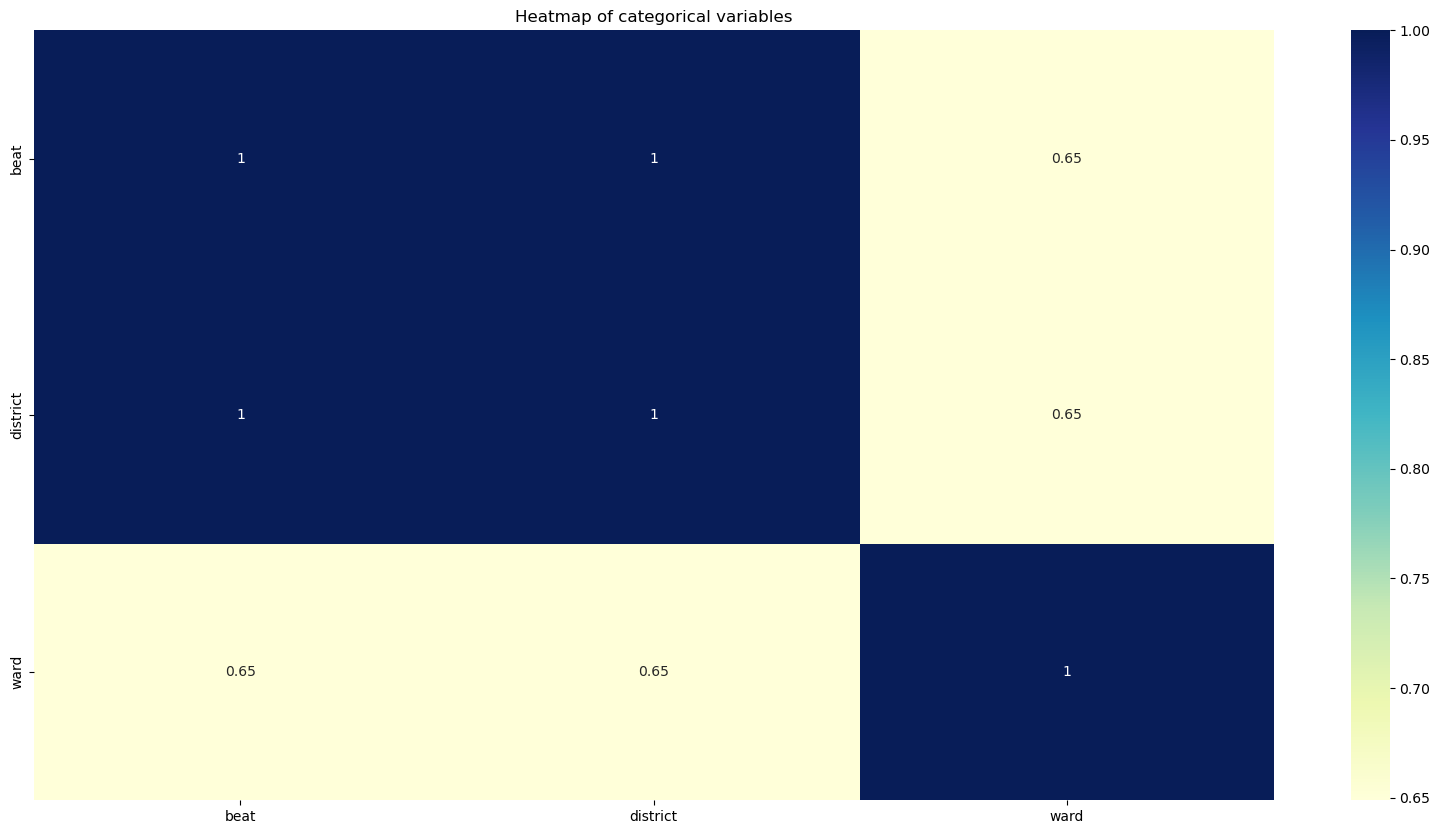

In [64]:
categorical_features = ['beat', 'district', 'ward']
co = df[categorical_features]
plt.figure(figsize=(20, 10))
sns.heatmap(co.corr(), annot = True, cmap="YlGnBu")
plt.title('Heatmap of categorical variables')
plt.show()

#### district/ward/community_area (one of these): Since these 3 are multicollinear we can just use one of them 

In [65]:
df.drop(columns=['block','ward','community_area'], inplace=True)
df

,date,primary_type,location_description,arrest,domestic,beat,district,year,latitude,longitude,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday
0,2021-12-22 06:00:00+00:00,MOTOR VEHICLE THEFT,STREET,False,False,321,3.0,2021,41.776110,-87.603399,2021,12,22,6,0,2,Tuesday
1,2018-06-19 11:00:00+00:00,THEFT,RESIDENCE,False,False,331,3.0,2018,41.769168,-87.568224,2018,6,19,11,0,1,Monday
2,2018-08-07 08:05:00+00:00,NARCOTICS,SIDEWALK,True,False,511,5.0,2018,NaN,NaN,2018,8,7,8,5,1,Monday
4,2020-02-09 06:20:00+00:00,DECEPTIVE PRACTICE,RESTAURANT,True,False,111,1.0,2020,41.888073,-87.625384,2020,2,9,6,20,6,Saturday
6,2018-05-22 02:15:00+00:00,OTHER OFFENSE,APARTMENT,False,True,321,3.0,2018,41.776159,-87.602185,2018,5,22,2,15,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,2021-11-24 08:50:00+00:00,OTHER OFFENSE,STREET,False,True,424,4.0,2021,41.735034,-87.545782,2021,11,24,8,50,2,Tuesday
926745,2019-10-28 12:00:00+00:00,OTHER OFFENSE,STREET,False,False,824,8.0,2019,41.786437,-87.691742,2019,10,28,12,0,0,Sunday
926746,2022-03-30 04:00:00+00:00,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,1223,12.0,2022,41.882104,-87.684752,2022,3,30,4,0,2,Tuesday
926747,2020-12-19 10:00:00+00:00,OTHER OFFENSE,STREET,False,True,1132,11.0,2020,41.873434,-87.726709,2020,12,19,10,0,5,Friday


In [66]:
df.drop(columns=['beat'], inplace=True)
df

,date,primary_type,location_description,arrest,domestic,district,year,latitude,longitude,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday
0,2021-12-22 06:00:00+00:00,MOTOR VEHICLE THEFT,STREET,False,False,3.0,2021,41.776110,-87.603399,2021,12,22,6,0,2,Tuesday
1,2018-06-19 11:00:00+00:00,THEFT,RESIDENCE,False,False,3.0,2018,41.769168,-87.568224,2018,6,19,11,0,1,Monday
2,2018-08-07 08:05:00+00:00,NARCOTICS,SIDEWALK,True,False,5.0,2018,NaN,NaN,2018,8,7,8,5,1,Monday
4,2020-02-09 06:20:00+00:00,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,2020,41.888073,-87.625384,2020,2,9,6,20,6,Saturday
6,2018-05-22 02:15:00+00:00,OTHER OFFENSE,APARTMENT,False,True,3.0,2018,41.776159,-87.602185,2018,5,22,2,15,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,2021-11-24 08:50:00+00:00,OTHER OFFENSE,STREET,False,True,4.0,2021,41.735034,-87.545782,2021,11,24,8,50,2,Tuesday
926745,2019-10-28 12:00:00+00:00,OTHER OFFENSE,STREET,False,False,8.0,2019,41.786437,-87.691742,2019,10,28,12,0,0,Sunday
926746,2022-03-30 04:00:00+00:00,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,2022,41.882104,-87.684752,2022,3,30,4,0,2,Tuesday
926747,2020-12-19 10:00:00+00:00,OTHER OFFENSE,STREET,False,True,11.0,2020,41.873434,-87.726709,2020,12,19,10,0,5,Friday


### Feature  Engineering

#### Creating indicator and interaction variables

Creating a **Covid indicator variable (Pre-Covid, Lockdown, Covid, Post-Covid)** to capture potential crime trends during different pandemic stages. This leverages expert knowledge to enrich the model with potentially relevant factors.


In [67]:

lockdown_start_year = 2020
lockdown_start_month = 3
lockdown_start_day = 15

lockdown_end_year = 2020
lockdown_end_month = 6
lockdown_end_day = 15

def add_covid_indicator(df):
  """
  This function adds a new column named 'covid_phase' to the dataframe 'df'.
  The new column indicates the COVID-19 phase based on year, month, and day.
  """
  df['covid_phase'] = 'Pre-COVID'
  lockdown_start_date = pd.to_datetime(f'{lockdown_start_year}-{lockdown_start_month}-{lockdown_start_day}')
  lockdown_end_date = pd.to_datetime(f'{lockdown_end_year}-{lockdown_end_month}-{lockdown_end_day}')
    
  df['date'] = df['date'].dt.tz_localize(None)
  
  df.loc[df['date'] < lockdown_start_date, 'covid_phase'] = 'Pre-COVID'
  df.loc[(df['date'] >= lockdown_start_date) & (df['date'] < lockdown_end_date), 'covid_phase'] = 'Lockdown'
  df.loc[df['date'] >= lockdown_end_date, 'covid_phase'] = 'COVID'
  df.loc[df['date'] >= pd.to_datetime('2022-04-16'), 'covid_phase'] = 'Post-COVID'
  
  df.drop('date', axis=1, inplace=True)  
  return df

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 841636 entries, 0 to 926748
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   date                  841636 non-null  datetime64[ns, UTC]
 1   primary_type          841636 non-null  object             
 2   location_description  836901 non-null  object             
 3   arrest                841636 non-null  bool               
 4   domestic              841636 non-null  bool               
 5   district              841636 non-null  float64            
 6   year                  841636 non-null  int64              
 7   latitude              828807 non-null  float64            
 8   longitude             828807 non-null  float64            
 9   Date_year             841636 non-null  int32              
 10  Date_month            841636 non-null  int32              
 11  Date_day              841636 non-null  int32             

In [69]:
# Add the new column with the COVID-19 indicator variable
df = add_covid_indicator(df.copy())

# Print the dataframe head to see the new column
df

,primary_type,location_description,arrest,domestic,district,year,latitude,longitude,Date_year,Date_month,Date_day,Date_hour,Date_minute,Date_weekday,weekday,covid_phase
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,2021,41.776110,-87.603399,2021,12,22,6,0,2,Tuesday,COVID
1,THEFT,RESIDENCE,False,False,3.0,2018,41.769168,-87.568224,2018,6,19,11,0,1,Monday,Pre-COVID
2,NARCOTICS,SIDEWALK,True,False,5.0,2018,NaN,NaN,2018,8,7,8,5,1,Monday,Pre-COVID
4,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,2020,41.888073,-87.625384,2020,2,9,6,20,6,Saturday,Pre-COVID
6,OTHER OFFENSE,APARTMENT,False,True,3.0,2018,41.776159,-87.602185,2018,5,22,2,15,1,Monday,Pre-COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,OTHER OFFENSE,STREET,False,True,4.0,2021,41.735034,-87.545782,2021,11,24,8,50,2,Tuesday,COVID
926745,OTHER OFFENSE,STREET,False,False,8.0,2019,41.786437,-87.691742,2019,10,28,12,0,0,Sunday,Pre-COVID
926746,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,2022,41.882104,-87.684752,2022,3,30,4,0,2,Tuesday,COVID
926747,OTHER OFFENSE,STREET,False,True,11.0,2020,41.873434,-87.726709,2020,12,19,10,0,5,Friday,COVID


In [70]:
df.drop(columns=['Date_hour','Date_minute','year'], inplace=True)
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,Date_day,Date_weekday,weekday,covid_phase
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,22,2,Tuesday,COVID
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,19,1,Monday,Pre-COVID
2,NARCOTICS,SIDEWALK,True,False,5.0,NaN,NaN,2018,8,7,1,Monday,Pre-COVID
4,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,9,6,Saturday,Pre-COVID
6,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,22,1,Monday,Pre-COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,24,2,Tuesday,COVID
926745,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,28,0,Sunday,Pre-COVID
926746,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,30,2,Tuesday,COVID
926747,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,19,5,Friday,COVID


Date (original format): Splitting it into year, month, day etc. provides more informative features for analysis. Since we have already done that we dont need the Date in original format.

Date_minute,Date_Hour: The extra granularity of minutes might not be significant for crime type prediction.

In [72]:
duplicate = df[df.duplicated()]
duplicate

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,Date_day,Date_weekday,weekday,covid_phase
3302,NARCOTICS,SIDEWALK,True,False,11.0,41.899808,-87.724990,2019,6,19,2,Tuesday,Pre-COVID
4480,NARCOTICS,GOVERNMENT BUILDING / PROPERTY,True,False,16.0,NaN,NaN,2022,6,27,0,Sunday,Post-COVID
15502,THEFT,DRUG STORE,False,False,17.0,41.941592,-87.727261,2021,6,8,1,Monday,COVID
15528,THEFT,GROCERY FOOD STORE,True,False,19.0,41.946212,-87.646580,2019,8,18,6,Saturday,Pre-COVID
15913,THEFT,PARK PROPERTY,False,False,1.0,41.884335,-87.619164,2021,7,30,4,Thursday,COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
926078,NARCOTICS,SIDEWALK,True,False,11.0,NaN,NaN,2021,7,26,0,Sunday,COVID
926119,OTHER OFFENSE,RESIDENCE,False,True,15.0,41.899096,-87.755701,2019,5,8,2,Tuesday,Pre-COVID
926517,OTHER OFFENSE,APARTMENT,False,False,16.0,NaN,NaN,2022,5,1,6,Saturday,Post-COVID
926519,OTHER OFFENSE,RESIDENCE,False,True,1.0,41.842983,-87.623323,2021,1,29,4,Thursday,COVID


In [73]:
# dropping the duplicate rows 
df = df.drop_duplicates()
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,Date_day,Date_weekday,weekday,covid_phase
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,22,2,Tuesday,COVID
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,19,1,Monday,Pre-COVID
2,NARCOTICS,SIDEWALK,True,False,5.0,NaN,NaN,2018,8,7,1,Monday,Pre-COVID
4,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,9,6,Saturday,Pre-COVID
6,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,22,1,Monday,Pre-COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
926744,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,24,2,Tuesday,COVID
926745,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,28,0,Sunday,Pre-COVID
926746,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,30,2,Tuesday,COVID
926747,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,19,5,Friday,COVID


In [75]:
df.reset_index(inplace=True)

In [76]:
df.drop(columns=['index'], inplace=True)
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,Date_day,Date_weekday,weekday,covid_phase
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,22,2,Tuesday,COVID
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,19,1,Monday,Pre-COVID
2,NARCOTICS,SIDEWALK,True,False,5.0,NaN,NaN,2018,8,7,1,Monday,Pre-COVID
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,9,6,Saturday,Pre-COVID
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,22,1,Monday,Pre-COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,24,2,Tuesday,COVID
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,28,0,Sunday,Pre-COVID
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,30,2,Tuesday,COVID
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,19,5,Friday,COVID


In [77]:
df.isnull().sum()

primary_type                0
location_description     4668
arrest                      0
domestic                    0
district                    0
latitude                12126
longitude               12126
Date_year                   0
Date_month                  0
Date_day                    0
Date_weekday                0
weekday                     0
covid_phase                 0
dtype: int64

In [79]:
df = df.dropna(subset=['latitude'])
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,Date_day,Date_weekday,weekday,covid_phase
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,22,2,Tuesday,COVID
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,19,1,Monday,Pre-COVID
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,9,6,Saturday,Pre-COVID
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,22,1,Monday,Pre-COVID
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,4,6,Saturday,Post-COVID
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,24,2,Tuesday,COVID
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,28,0,Sunday,Pre-COVID
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,30,2,Tuesday,COVID
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,19,5,Friday,COVID


Since we have a relatively small percentage (1.5%) of missing latitude/longitude values. We can remove the rows.

Constructing interaction features **"proximity" (Far/Close) and "distance" to major locations** in Chicago for each crime incident. This captures the spatial context of crimes relative to significant landmarks by considering both closeness and actual distance.


In [80]:
from geopy.distance import geodesic
major_locations = [
    ("Millennium Park", 41.8825, -87.6231),
    ("Navy Pier", 41.9004, -87.6169),
    ("Wrigley Field", 41.9481, -87.6561),
    ("Lincoln Park Zoo", 41.9233, -87.6317),
    ("Art Institute of Chicago", 41.8879, -87.6231),
    ("Shedd Aquarium", 41.8871, -87.6336),
    ("Willis Tower (Sears Tower)", 41.8886, -87.6359),
    ("United Center", 41.8849, -87.6741),
    ("Magnificent Mile", 41.9028, -87.6231),  
    ("Grant Park", 41.8822, -87.6219), 
    ("360 Chicago Observation Deck", 41.9019, -87.6332),
    ("Museum of Science and Industry", 41.8625, -87.6219),
    ("Garfield Park Conservatory", 41.9028, -87.7222)
]


def calculate_proximity_and_distance(data):
  """
  This function calculates both proximity and distance to major locations for each crime incident.

  Args:
      data: A pandas DataFrame containing crime data.

  Returns:
      A new DataFrame with additional columns "proximity" and "distance_meters" indicating proximity category and distance to major locations.
  """
  data["proximity"] = "Far"  # Default proximity value for all crimes
  data["distance_meters"] = None  # Initialize distance column with None

  for crime_index, row in data.iterrows():
    crime_lat = row["latitude"]
    crime_lon = row["longitude"]
    closest_distance = float('inf')  # Initialize to positive infinity for comparison
    closest_location_name = None

    for location_name, location_lat, location_lon in major_locations:
      distance = geodesic((crime_lat, crime_lon), (location_lat, location_lon)).meters
      if distance < closest_distance:
        closest_distance = distance
        closest_location_name = location_name

    # Set proximity based on a threshold
    if closest_distance <= 1600:  # Set 1 mile as the threshold (1600 meters)
      data.at[crime_index, "proximity"] = "Close"
    
    # Update distance for the closest major location
    data.at[crime_index, "distance_meters"] = closest_distance

  return data

In [81]:
df = calculate_proximity_and_distance(df.copy())
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,Date_day,Date_weekday,weekday,covid_phase,proximity,distance_meters
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,22,2,Tuesday,COVID,Far,9717.707604
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,19,1,Monday,Pre-COVID,Far,11285.009309
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,9,6,Saturday,Pre-COVID,Close,190.548453
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,22,1,Monday,Pre-COVID,Far,9728.70823
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,4,6,Saturday,Post-COVID,Far,11057.038248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,24,2,Tuesday,COVID,Far,15506.728092
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,28,0,Sunday,Pre-COVID,Far,10248.975714
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,30,2,Tuesday,COVID,Close,937.131226
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,19,5,Friday,COVID,Far,3283.157337


In [83]:
df.drop(columns=['Date_weekday','Date_day'], inplace=True)
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337


We dont need granularity till days to make prediction about type of crime . We already have Weekday which can be helpful . Also Date_weekday and weekday convery the same information.

Here's the breakdown of the real-world flow:

Crime occurs: A crime takes place, like theft, assault, or domestic violence.

Investigation: Police investigate the scene and gather evidence. This might involve interviewing witnesses or the victim.

Arrest: Based on the investigation, if there's probable cause, an arrest might be made.

Crime classification: Law enforcement determines the appropriate crime classification based on the nature of the offense.

In [86]:
df = df.dropna(subset=['location_description'])
df

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337


Since the count of rows with NULL values for location_description is less than 1% we can simple remove those rows.

Identified a large number of categories for location descriptions.

Many categories represented the same location type but with minor variations in wording (e.g., "HOTEL-," "HOTEL:").

Standardized these variations into a single category to improve data consistency and reduce noise.

This helps the model recognize similar locations more effectively.


In [87]:
def remove_special_chars(text):
  """
  This function removes forward slashes (/), commas (,), hyphens (-), spaces, and colons (:) from a string.
  """
  filtered_chars = [char for char in text if char not in "/,- ():"]
  return "".join(filtered_chars)

def combine_ride_sharing(category):
  """
  This function combines categories related to ride-sharing services (Uber, Lyft, etc.).
  """
  cleaned_category = remove_special_chars(category)
  if "OTHERRIDESHARESERVICE" in cleaned_category:
    return "VEHICLEOTHERRIDESHARESERVICE"
  else:
    return cleaned_category

In [88]:
def combine_columns(category):
  """
  This function identifies categories containing "RESIDENCE" and returns a single category.
  """
  if "VEHICLE" in category:
    category = combine_ride_sharing(category)
    return category
  if "RESIDENCE" in category and "COLLEGE" not in category or "RESIDENTIAL" in category and "NON" not in category: 
    return "RESIDENCE"
  if "OTHER" in category and "VEHICLE" not in category:
    return "OTHER"
  if "SCHOOL" in category:
    return "SCHOOL"
  if "AIRPORT" in category:
    return "AIRPORT"
  if "COLLEGE" in category:
    return "COLLEGE"
  else:
    return category


In [89]:
df_cleaned = df.copy()
df_cleaned["cleaned_category"] = df_cleaned['location_description'].apply(combine_columns)
df_cleaned

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters,cleaned_category
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604,STREET
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309,RESIDENCE
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453,RESTAURANT
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823,APARTMENT
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248,APARTMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092,STREET
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714,STREET
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226,RESIDENCE
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337,STREET


In [90]:
df_cleaned2 = df.copy()
df_cleaned2["cleaned_category"] = df_cleaned2['location_description'].apply(combine_columns)
df_cleaned2

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters,cleaned_category
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604,STREET
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309,RESIDENCE
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453,RESTAURANT
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823,APARTMENT
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248,APARTMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092,STREET
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714,STREET
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226,RESIDENCE
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337,STREET


In [93]:
def combine_columns_phase2(category):
  """
  This function identifies categories and returns a single category.
  """
  if "CTA" in category:
    return "CTA"
  if "HOSPITAL" in category: 
    return "HOSPITAL"
  if "HOTEL" in category:
    return "HOTEL"
  if "CHURCH" in category:
    return "CHURCH"
  if "SPORT" in category or "ATHLETIC" in category:
    return "SPORTS"
  if "MOVIE" in category:
    return "MOVIE THEATER"
  if "PARKING" in category:
    return "PARKING"
  if "RIVERBANK" in category:
    return "RIVERBANK"
  else:
    return category


In [94]:
df_cleaned2["cleaned_category"] = df_cleaned2["cleaned_category"].apply(combine_columns_phase2)
df_cleaned2

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters,cleaned_category
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604,STREET
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309,RESIDENCE
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453,RESTAURANT
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823,APARTMENT
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248,APARTMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092,STREET
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714,STREET
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226,RESIDENCE
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337,STREET


In [95]:
def combine_columns_phase3(category):
  """
  This function identifies categories and returns a single category.
  """
  if "NURSING" in category:
    return "NURSING"
  if "TAVERN" in category: 
    return "TAVERN"
  if "BOAT" in category:
    return "BOAT"
  if "MEDICAL" in category:
    return "MEDICAL"
  if "GOVERNMENT BUILDING" in category:
    return "GOVERNMENT BUILDING"
  if "ELEVATOR" in category:
    return "ELEVATOR"
  if "FACTORY" in category:
    return "FACTORY"
  if "HIGHWAY" in category:
    return "HIGHWAY"
  else:
    return category


In [96]:
df_cleaned2["cleaned_category"] = df_cleaned2["cleaned_category"].apply(combine_columns_phase3)
df_cleaned2

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters,cleaned_category
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604,STREET
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309,RESIDENCE
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453,RESTAURANT
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823,APARTMENT
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248,APARTMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092,STREET
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714,STREET
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226,RESIDENCE
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337,STREET


In [98]:
df_cleaned2

,primary_type,location_description,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters,cleaned_category
0,MOTOR VEHICLE THEFT,STREET,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604,STREET
1,THEFT,RESIDENCE,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309,RESIDENCE
3,DECEPTIVE PRACTICE,RESTAURANT,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453,RESTAURANT
4,OTHER OFFENSE,APARTMENT,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823,APARTMENT
5,BATTERY,APARTMENT,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248,APARTMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,STREET,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092,STREET
835740,OTHER OFFENSE,STREET,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714,STREET
835741,OTHER OFFENSE,DRIVEWAY - RESIDENTIAL,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226,RESIDENCE
835742,OTHER OFFENSE,STREET,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337,STREET


In [99]:
df_cleaned2.drop(columns=['location_description'], inplace=True)
df_cleaned2

,primary_type,arrest,domestic,district,latitude,longitude,Date_year,Date_month,weekday,covid_phase,proximity,distance_meters,cleaned_category
0,MOTOR VEHICLE THEFT,False,False,3.0,41.776110,-87.603399,2021,12,Tuesday,COVID,Far,9717.707604,STREET
1,THEFT,False,False,3.0,41.769168,-87.568224,2018,6,Monday,Pre-COVID,Far,11285.009309,RESIDENCE
3,DECEPTIVE PRACTICE,True,False,1.0,41.888073,-87.625384,2020,2,Saturday,Pre-COVID,Close,190.548453,RESTAURANT
4,OTHER OFFENSE,False,True,3.0,41.776159,-87.602185,2018,5,Monday,Pre-COVID,Far,9728.70823,APARTMENT
5,BATTERY,False,False,3.0,41.768956,-87.576376,2024,2,Saturday,Post-COVID,Far,11057.038248,APARTMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,False,True,4.0,41.735034,-87.545782,2021,11,Tuesday,COVID,Far,15506.728092,STREET
835740,OTHER OFFENSE,False,False,8.0,41.786437,-87.691742,2019,10,Sunday,Pre-COVID,Far,10248.975714,STREET
835741,OTHER OFFENSE,False,False,12.0,41.882104,-87.684752,2022,3,Tuesday,COVID,Close,937.131226,RESIDENCE
835742,OTHER OFFENSE,False,True,11.0,41.873434,-87.726709,2020,12,Friday,COVID,Far,3283.157337,STREET


In [100]:
df_cleaned2.columns

Index(['primary_type', 'arrest', 'domestic', 'district', 'latitude',
       'longitude', 'Date_year', 'Date_month', 'weekday', 'covid_phase',
       'proximity', 'distance_meters', 'cleaned_category'],
      dtype='object')

#### One hot encoding the categorical features

In [101]:
df_cleaned4 = df_cleaned2.copy()
# one hot encoding for converting the categorical variable to numerical
df_cleaned4 = pd.get_dummies(df_cleaned4, columns=['arrest','domestic','district','Date_year','Date_month','weekday','covid_phase','proximity','cleaned_category'], drop_first=True,dtype=int)
df_cleaned4

,primary_type,latitude,longitude,distance_meters,arrest_True,domestic_True,district_2.0,district_3.0,district_4.0,district_5.0,...,cleaned_category_TAXICAB,cleaned_category_VACANT LOT / LAND,cleaned_category_VACANT LOT/LAND,cleaned_category_VEHICLECOMMERCIAL,cleaned_category_VEHICLECOMMERCIALENTERTAINMENTPARTYBUS,cleaned_category_VEHICLECOMMERCIALTROLLEYBUS,cleaned_category_VEHICLEDELIVERYTRUCK,cleaned_category_VEHICLENONCOMMERCIAL,cleaned_category_VEHICLEOTHERRIDESHARESERVICE,cleaned_category_WAREHOUSE
0,MOTOR VEHICLE THEFT,41.776110,-87.603399,9717.707604,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,THEFT,41.769168,-87.568224,11285.009309,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DECEPTIVE PRACTICE,41.888073,-87.625384,190.548453,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,OTHER OFFENSE,41.776159,-87.602185,9728.70823,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,BATTERY,41.768956,-87.576376,11057.038248,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,OTHER OFFENSE,41.735034,-87.545782,15506.728092,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
835740,OTHER OFFENSE,41.786437,-87.691742,10248.975714,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835741,OTHER OFFENSE,41.882104,-87.684752,937.131226,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835742,OTHER OFFENSE,41.873434,-87.726709,3283.157337,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Label encoding the target variable

In [102]:
from sklearn.preprocessing import LabelEncoder
# Label encoding the target variable
le = LabelEncoder()
df_cleaned4['primary_type'] = le.fit_transform(df_cleaned4['primary_type'])
df_cleaned4

,primary_type,latitude,longitude,distance_meters,arrest_True,domestic_True,district_2.0,district_3.0,district_4.0,district_5.0,...,cleaned_category_TAXICAB,cleaned_category_VACANT LOT / LAND,cleaned_category_VACANT LOT/LAND,cleaned_category_VEHICLECOMMERCIAL,cleaned_category_VEHICLECOMMERCIALENTERTAINMENTPARTYBUS,cleaned_category_VEHICLECOMMERCIALTROLLEYBUS,cleaned_category_VEHICLEDELIVERYTRUCK,cleaned_category_VEHICLENONCOMMERCIAL,cleaned_category_VEHICLEOTHERRIDESHARESERVICE,cleaned_category_WAREHOUSE
0,5,41.776110,-87.603399,9717.707604,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,41.769168,-87.568224,11285.009309,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,41.888073,-87.625384,190.548453,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,41.776159,-87.602185,9728.70823,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,41.768956,-87.576376,11057.038248,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835739,7,41.735034,-87.545782,15506.728092,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
835740,7,41.786437,-87.691742,10248.975714,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835741,7,41.882104,-87.684752,937.131226,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
835742,7,41.873434,-87.726709,3283.157337,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
labels = le.classes_

# Create a mapping dictionary
label_mapping = dict(zip(range(len(labels)), labels))
print(label_mapping)

{0: 'ASSAULT', 1: 'BATTERY', 2: 'BURGLARY', 3: 'CRIMINAL DAMAGE', 4: 'DECEPTIVE PRACTICE', 5: 'MOTOR VEHICLE THEFT', 6: 'NARCOTICS', 7: 'OTHER OFFENSE', 8: 'ROBBERY', 9: 'THEFT'}


In [103]:
# Converting the meters to miles
df_cleaned4['distance_miles'] = df_cleaned4['distance_meters'].apply(lambda x : x / 1600)

In [104]:
df_cleaned4[['distance_miles','distance_meters']]

,distance_miles,distance_meters
0,6.073567,9717.707604
1,7.053131,11285.009309
3,0.119093,190.548453
4,6.080443,9728.70823
5,6.910649,11057.038248
...,...,...
835739,9.691705,15506.728092
835740,6.405610,10248.975714
835741,0.585707,937.131226
835742,2.051973,3283.157337


In [105]:
pd.set_option('display.max_columns', None)
df_cleaned4

,primary_type,latitude,longitude,distance_meters,arrest_True,domestic_True,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,district_12.0,district_14.0,district_15.0,district_16.0,district_17.0,district_18.0,district_19.0,district_20.0,district_22.0,district_24.0,district_25.0,district_31.0,Date_year_2019,Date_year_2020,Date_year_2021,Date_year_2022,Date_year_2023,Date_year_2024,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,Date_month_11,Date_month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,covid_phase_Lockdown,covid_phase_Post-COVID,covid_phase_Pre-COVID,proximity_Far,cleaned_category_AIRCRAFT,cleaned_category_AIRPORT,cleaned_category_ALLEY,cleaned_category_APARTMENT,cleaned_category_APPLIANCE STORE,cleaned_category_ATM (AUTOMATIC TELLER MACHINE),cleaned_category_BANK,cleaned_category_BARBERSHOP,cleaned_category_BOAT,cleaned_category_BOWLING ALLEY,cleaned_category_BRIDGE,cleaned_category_CAR WASH,cleaned_category_CEMETARY,cleaned_category_CHA APARTMENT,cleaned_category_CHURCH,cleaned_category_CLEANING STORE,cleaned_category_COIN OPERATED MACHINE,cleaned_category_COLLEGE,cleaned_category_COMMERCIAL / BUSINESS OFFICE,cleaned_category_CONSTRUCTION SITE,cleaned_category_CONVENIENCE STORE,cleaned_category_CREDIT UNION,cleaned_category_CTA,cleaned_category_CURRENCY EXCHANGE,cleaned_category_DAY CARE CENTER,cleaned_category_DEPARTMENT STORE,cleaned_category_DRUG STORE,cleaned_category_ELEVATOR,cleaned_category_FACTORY,cleaned_category_FARM,cleaned_category_FEDERAL BUILDING,cleaned_category_FIRE STATION,cleaned_category_FOREST PRESERVE,cleaned_category_GAS STATION,cleaned_category_GOVERNMENT BUILDING,cleaned_category_GROCERY FOOD STORE,cleaned_category_HIGHWAY,cleaned_category_HORSE STABLE,cleaned_category_HOSPITAL,cleaned_category_HOTEL,cleaned_category_JAIL / LOCK-UP FACILITY,cleaned_category_KENNEL,cleaned_category_LIBRARY,cleaned_category_MEDICAL,cleaned_category_MOVIE THEATER,cleaned_category_NEWSSTAND,cleaned_category_NURSING,cleaned_category_OTHER,cleaned_category_PARK PROPERTY,cleaned_category_PARKING,cleaned_category_PAWN SHOP,cleaned_category_POOL ROOM,cleaned_category_RESIDENCE,cleaned_category_RESTAURANT,cleaned_category_RIVERBANK,cleaned_category_SAVINGS AND LOAN,cleaned_category_SCHOOL,cleaned_category_SIDEWALK,cleaned_category_SMALL RETAIL STORE,cleaned_category_SPORTS,cleaned_category_STREET,cleaned_category_TAVERN,cleaned_category_TAXICAB,cleaned_category_VACANT LOT / LAND,cleaned_category_VACANT LOT/LAND,cleaned_category_VEHICLECOMMERCIAL,cleaned_category_VEHICLECOMMERCIALENTERTAINMENTPARTYBUS,cleaned_category_VEHICLECOMMERCIALTROLLEYBUS,cleaned_category_VEHICLEDELIVERYTRUCK,cleaned_category_VEHICLENONCOMMERCIAL,cleaned_category_VEHICLEOTHERRIDESHARESERVICE,cleaned_category_WAREHOUSE,distance_miles
0,5,41.776110,-87.603399,9717.707604,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.073567
1,9,41.769168,-87.568224,11285.009309,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.053131
3,4,41.888073,-87.625384,190.548453,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.119093
4,7,41.776159,-87.602185,9728.70823,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,

In [106]:
# creating a backup
backup1 = df_cleaned4.copy()

In [107]:
df_cleaned4 = df_cleaned4.drop('distance_meters', axis=1)

In [108]:
df_cleaned4

,primary_type,latitude,longitude,arrest_True,domestic_True,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,district_12.0,district_14.0,district_15.0,district_16.0,district_17.0,district_18.0,district_19.0,district_20.0,district_22.0,district_24.0,district_25.0,district_31.0,Date_year_2019,Date_year_2020,Date_year_2021,Date_year_2022,Date_year_2023,Date_year_2024,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_month_10,Date_month_11,Date_month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,covid_phase_Lockdown,covid_phase_Post-COVID,covid_phase_Pre-COVID,proximity_Far,cleaned_category_AIRCRAFT,cleaned_category_AIRPORT,cleaned_category_ALLEY,cleaned_category_APARTMENT,cleaned_category_APPLIANCE STORE,cleaned_category_ATM (AUTOMATIC TELLER MACHINE),cleaned_category_BANK,cleaned_category_BARBERSHOP,cleaned_category_BOAT,cleaned_category_BOWLING ALLEY,cleaned_category_BRIDGE,cleaned_category_CAR WASH,cleaned_category_CEMETARY,cleaned_category_CHA APARTMENT,cleaned_category_CHURCH,cleaned_category_CLEANING STORE,cleaned_category_COIN OPERATED MACHINE,cleaned_category_COLLEGE,cleaned_category_COMMERCIAL / BUSINESS OFFICE,cleaned_category_CONSTRUCTION SITE,cleaned_category_CONVENIENCE STORE,cleaned_category_CREDIT UNION,cleaned_category_CTA,cleaned_category_CURRENCY EXCHANGE,cleaned_category_DAY CARE CENTER,cleaned_category_DEPARTMENT STORE,cleaned_category_DRUG STORE,cleaned_category_ELEVATOR,cleaned_category_FACTORY,cleaned_category_FARM,cleaned_category_FEDERAL BUILDING,cleaned_category_FIRE STATION,cleaned_category_FOREST PRESERVE,cleaned_category_GAS STATION,cleaned_category_GOVERNMENT BUILDING,cleaned_category_GROCERY FOOD STORE,cleaned_category_HIGHWAY,cleaned_category_HORSE STABLE,cleaned_category_HOSPITAL,cleaned_category_HOTEL,cleaned_category_JAIL / LOCK-UP FACILITY,cleaned_category_KENNEL,cleaned_category_LIBRARY,cleaned_category_MEDICAL,cleaned_category_MOVIE THEATER,cleaned_category_NEWSSTAND,cleaned_category_NURSING,cleaned_category_OTHER,cleaned_category_PARK PROPERTY,cleaned_category_PARKING,cleaned_category_PAWN SHOP,cleaned_category_POOL ROOM,cleaned_category_RESIDENCE,cleaned_category_RESTAURANT,cleaned_category_RIVERBANK,cleaned_category_SAVINGS AND LOAN,cleaned_category_SCHOOL,cleaned_category_SIDEWALK,cleaned_category_SMALL RETAIL STORE,cleaned_category_SPORTS,cleaned_category_STREET,cleaned_category_TAVERN,cleaned_category_TAXICAB,cleaned_category_VACANT LOT / LAND,cleaned_category_VACANT LOT/LAND,cleaned_category_VEHICLECOMMERCIAL,cleaned_category_VEHICLECOMMERCIALENTERTAINMENTPARTYBUS,cleaned_category_VEHICLECOMMERCIALTROLLEYBUS,cleaned_category_VEHICLEDELIVERYTRUCK,cleaned_category_VEHICLENONCOMMERCIAL,cleaned_category_VEHICLEOTHERRIDESHARESERVICE,cleaned_category_WAREHOUSE,distance_miles
0,5,41.776110,-87.603399,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.073567
1,9,41.769168,-87.568224,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.053131
3,4,41.888073,-87.625384,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.119093
4,7,41.776159,-87.602185,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [248]:
percentage_counts = df_cleaned4['primary_type'].value_counts(normalize=True) * 100
print(percentage_counts)

primary_type
9    24.295158
1    20.582211
3    12.438916
0     9.549930
4     7.298606
5     7.022692
7     6.936370
8     4.171625
2     3.974352
6     3.730139
Name: proportion, dtype: float64


## Prepped Data Review

In [110]:
def plot_numerical_features(df,feature):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    sns.histplot(data = df, x = feature,kde = True)
    plt.title('Histogram for {}'.format(feature))
    plt.xlabel(feature)


    plt.subplot(1, 2, 2) 
    sns.boxplot(df[feature])
    plt.title('Box Plot for  {}'.format(feature))
    plt.xlabel(feature)
    plt.show();

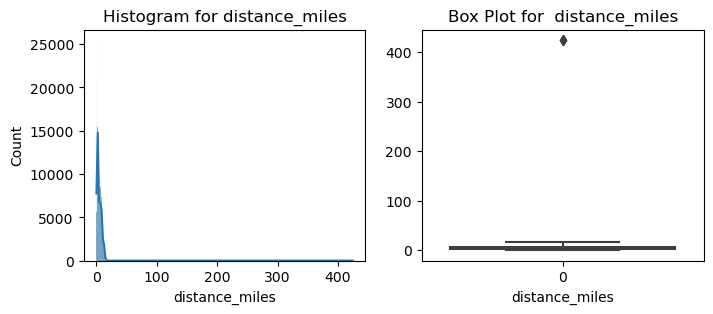

In [111]:
plot_numerical_features(df_cleaned4, 'distance_miles')

Distance miles follows a right skewed distribution . It has a single outlier.

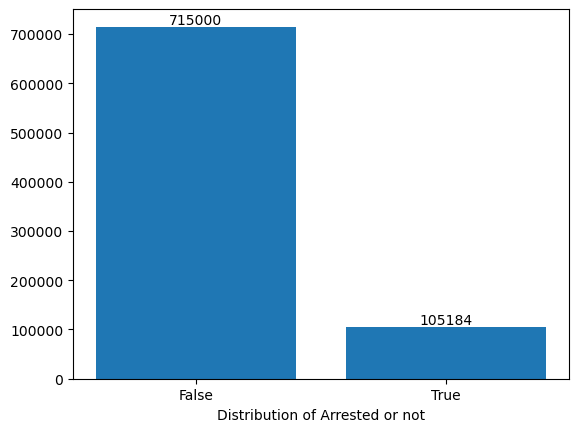

In [112]:
value_cnt = df_cleaned4['arrest_True'].value_counts()
plt.bar(value_cnt.index, value_cnt.values)

plt.xlabel('Arrest')
plt.xlabel('Count')
plt.xlabel('Distribution of Arrested or not')

for i, cnt in enumerate(value_cnt.values):
    plt.text(i, cnt, str(cnt), ha = 'center', va = 'bottom')

    
plt.xticks([0,1],['False', 'True'])

plt.show()

As we see for most of the crimes arrest did not happen.

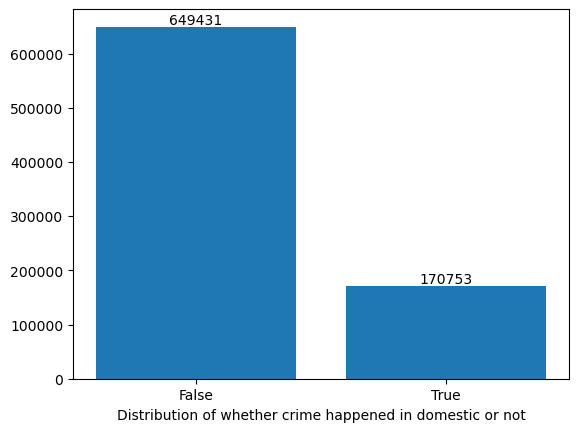

In [113]:
value_cnt = df_cleaned4['domestic_True'].value_counts()
plt.bar(value_cnt.index, value_cnt.values)

plt.xlabel('Domestic')
plt.xlabel('Count')
plt.xlabel('Distribution of whether crime happened in domestic or not')

for i, cnt in enumerate(value_cnt.values):
    plt.text(i, cnt, str(cnt), ha = 'center', va = 'bottom')

    
plt.xticks([0,1],['False', 'True'])

plt.show()

As we can see most of the crimes are not domestic.

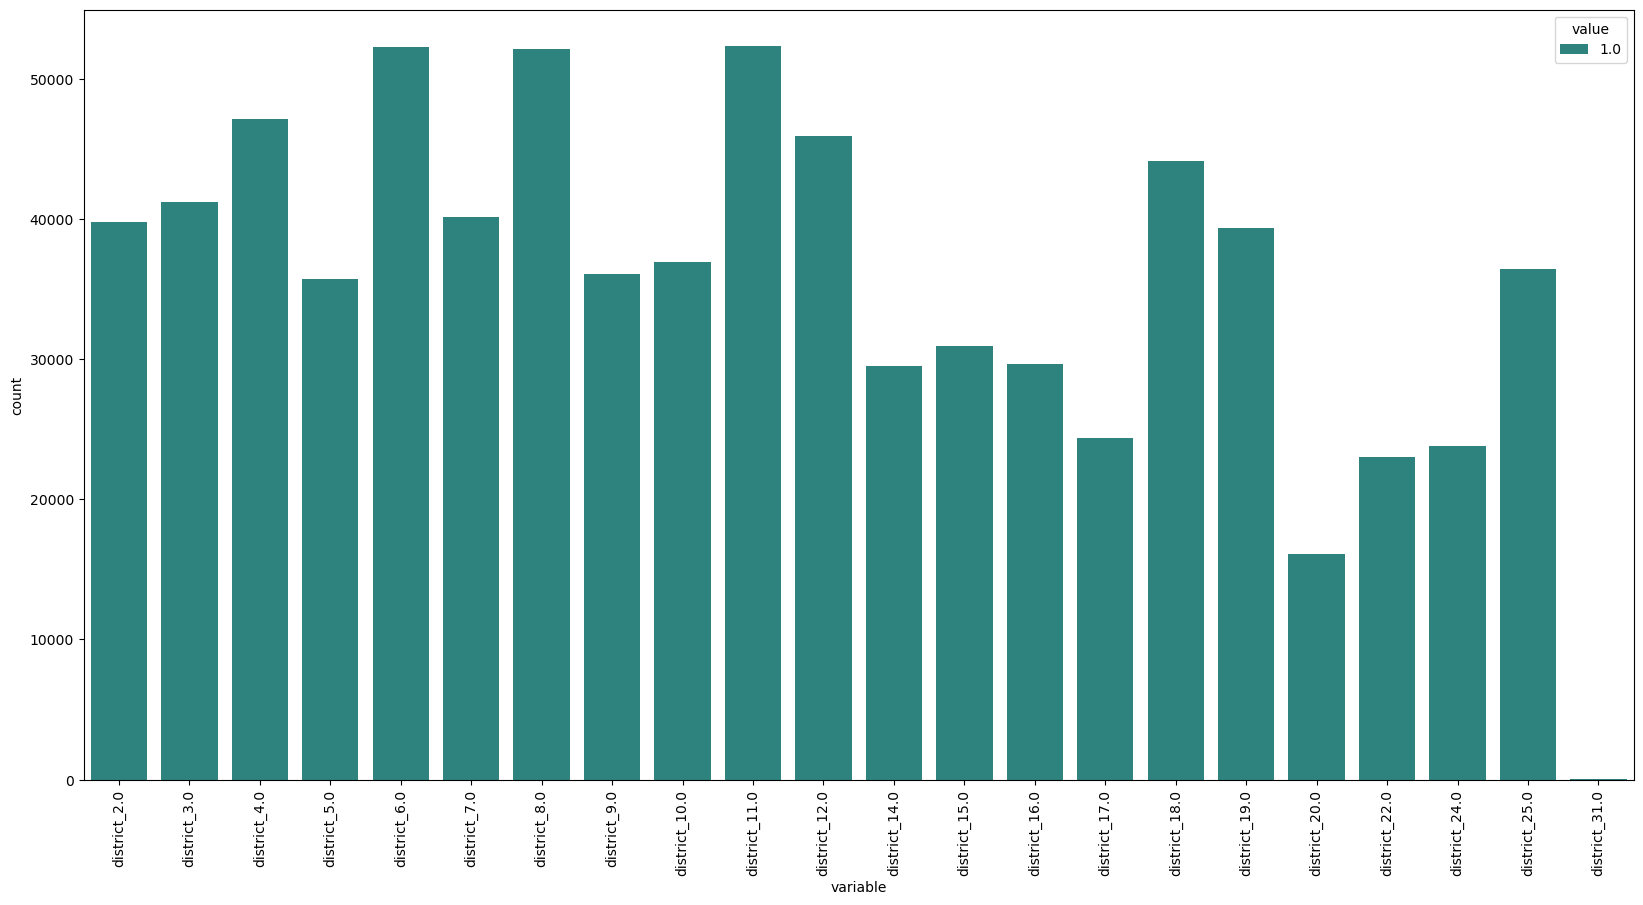

In [114]:
plt.figure(figsize=(20, 10))
district_df = df_cleaned4[['district_2.0','district_3.0','district_4.0','district_5.0',
'district_6.0','district_7.0','district_8.0','district_9.0',
'district_10.0','district_11.0','district_12.0','district_14.0',
'district_15.0','district_16.0','district_17.0','district_18.0',
'district_19.0','district_20.0','district_22.0','district_24.0','district_25.0','district_31.0']]

district_df = district_df[district_df == 1]

# Plot using Seaborn
sns.countplot(data=pd.melt(district_df), x='variable', hue='value', palette='viridis')
plt.xticks(rotation = 90)
plt.show()



Since we has already showed the bar chart of different districts this is just the dummy encoded variable of it and represents the same information.

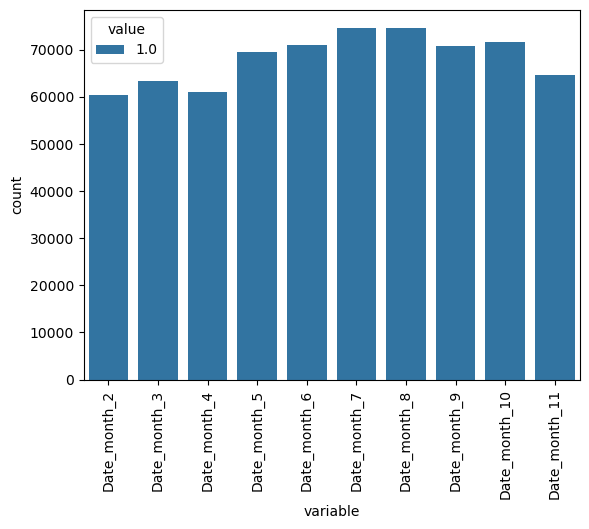

In [115]:
month_df = df_cleaned4[['Date_month_2','Date_month_3','Date_month_4','Date_month_5',
'Date_month_6','Date_month_7','Date_month_8','Date_month_9','Date_month_10','Date_month_11']]


month_df = month_df[month_df == 1]

# Plot using Seaborn
sns.countplot(data=pd.melt(month_df), x='variable', hue='value')
plt.xticks(rotation = 90)
plt.show()

As we see Month 6, 7 and Month 8 have the highest crimes . This could be because of the reason that more crimes usually occur in Summer.

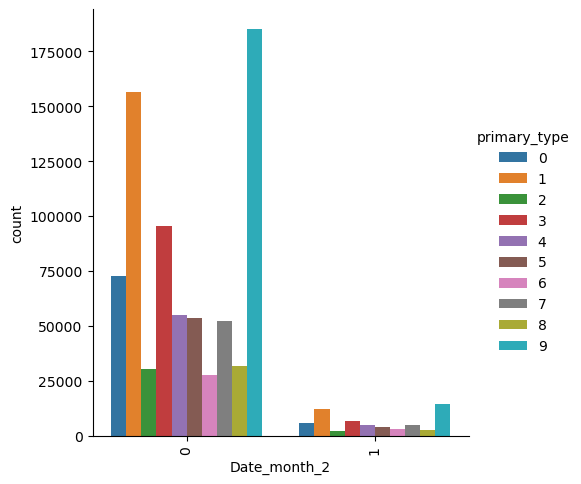

In [118]:
sns.catplot(x='Date_month_2', hue='primary_type', kind='count', data=df_cleaned4)
# plt.yscale('log')
plt.title('')
plt.xticks( rotation=90)
plt.show()

This graph is specific for the month February .There seems a common trend for months that are not February and February.

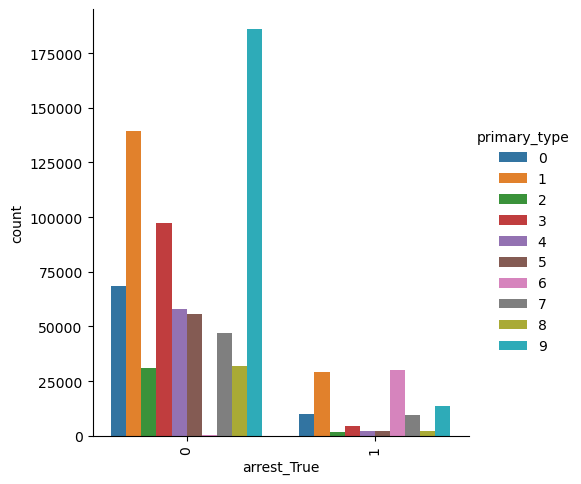

In [120]:
sns.catplot(x='arrest_True', hue='primary_type', kind='count', data=df_cleaned4)
# plt.yscale('log')
plt.title('')
plt.xticks( rotation=90)
plt.show()

One interesting thing about this plotis that there is almost no arrests for the arrest Type Narcotics . This means that Narcotics is one of the crimes that wont result in arrest.

## Machine Learning Models

In [122]:
# creating a backup dataframe
backup_data = df_cleaned4.copy()

In [123]:
def calculate_metrics(y_train,y_predict):
    # calculates the accuracy of the model's predictions on the training data
    acc = accuracy_score(y_train, y_predict)
    # creates a confusion matrix, which provides a detailed breakdown of the model's performance.
    conf_matrix = confusion_matrix(y_train, y_predict)
    # generates a classification report, which provides additional metrics such as precision, recall, F1-score, 
    # and support for each class.
    report = classification_report(y_train, y_predict)

    print(f"Accuracy: {acc}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{report}")

Train Test Splitting

In [124]:
from sklearn.model_selection import train_test_split
X = df_cleaned4.drop('primary_type', axis=1)
y = df_cleaned4['primary_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
print(X_train.shape)
print(y_train.shape)

(656147, 126)
(656147,)


In [126]:
print(X_test.shape)
print(y_test.shape)

(164037, 126)
(164037,)


#### Employing a Decision Tree Classifier model to identify the top 45 features most impactful in capturing data patterns relevant to crime prediction.

This data-driven approach ensures the model focuses on the most informative features for accurate results.


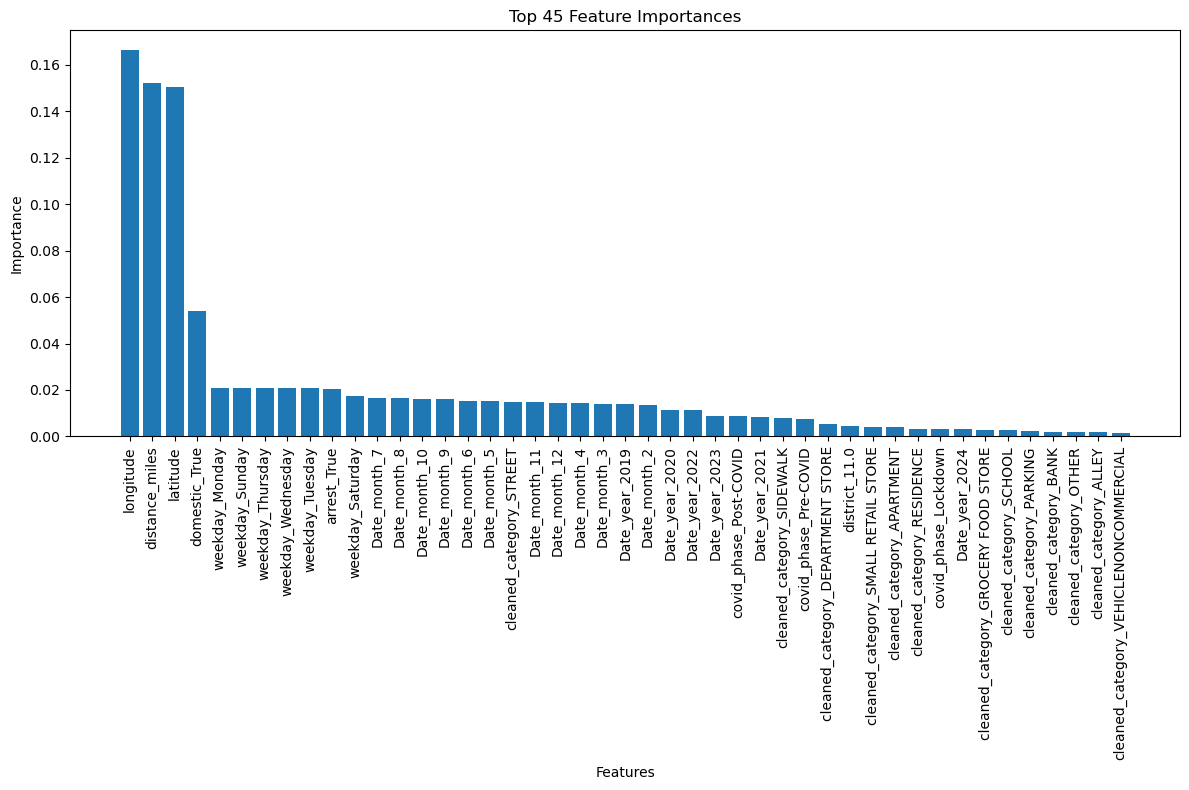

In [127]:
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train, X_test, y_train, y_test are already defined
# If not, please define them by splitting your dataset as you did previously

# Create a decision tree classifier
decision_tree = DecisionTreeClassifier()

# Train the classifier on the training data
decision_tree.fit(X_train, y_train)

# Get feature importances
feature_importances = decision_tree.feature_importances_

# Sort feature importances in descending order and get the top 30 indices
top_indices = np.argsort(feature_importances)[::-1][:45]

# Get the top 30 feature names
top_features = X_train.columns[top_indices]

# Plot the top 30 feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_features)), feature_importances[top_indices], align="center")
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.title("Top 45 Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

We identified the top 45 features that best capture our data's patterns using the DecisionTreeClassifier model.

## Random Forest Model

#### Hyperparameter Tuning

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'max_features': [2, 5, 10, 20]
}


# Instantiate the Random Forest classifier
rf = RandomForestClassifier()

# Instantiate the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV
grid_search.fit(X_train[top_features], y_train)

# Access the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 10, 'max_features': 20, 'n_estimators': 200}


In [135]:
ran_for = RandomForestClassifier(n_estimators=200, 
                                 max_depth=10, max_features=20, 
                                 random_state=42, oob_score=True)

In [136]:
ran_for.fit(X_train[top_features], y_train)

y_predict_rf_train = ran_for.predict(X_train[top_features])

calculate_metrics(y_train,y_predict_rf_train)

Accuracy: 0.5742905172164164
Confusion Matrix:
[[ 12838  19927    672   3793   1850   2517   1805    320    549  18342]
 [   438 100193    707   3776   1721   2646   2508    280    569  22205]
 [   112   1376   7292   2740   2405     70    274     92     21  11760]
 [   353  11555   1189  32845   3334   5556    977    221    373  25342]
 [   139   1268    846   2749  20907    469    471    142     61  20893]
 [   120   1084     70   2462    653  29489    721     90    293  11203]
 [    35   1234     22     25     36     84  22375    252     15    314]
 [   224  14280    699   2709   2729    968   2617  11238     93   9829]
 [   192   3080    145   1421    418   2687    567     57   9322   9426]
 [   316  10667   1173   5247   4471   5454    984    191    558 130320]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.21      0.33     62613
           1       0.61      0.74      0.67    135043
           2       0.57      0.28   

We achieved an accuracy of 57% for Random Forest for training set. The average recall for it was 50% , average precision is 66% . The average f1 score is 52%.

In [137]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each class
class_accuracies = {}
for class_label in np.unique(y_test):
    correct_predictions = (y_predict_rf_train == y_train)[y_train == class_label]
    accuracy = np.mean(correct_predictions)
    class_accuracies[class_label] = accuracy

print("Accuracy for each class:")
for class_label, accuracy in class_accuracies.items():
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")


Accuracy for each class:
Class 0: Accuracy 0.21
Class 1: Accuracy 0.74
Class 2: Accuracy 0.28
Class 3: Accuracy 0.40
Class 4: Accuracy 0.44
Class 5: Accuracy 0.64
Class 6: Accuracy 0.92
Class 7: Accuracy 0.25
Class 8: Accuracy 0.34
Class 9: Accuracy 0.82


We have identified the accuracies for each category .The Random Forest Model does a good job predicting Class 1,5,6 and Class 9 .

### XGBoostClassifier

#### Hyperparameter Tuning

In [138]:
import xgboost as xgb


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5,10],
    'learning_rate' : [0.01, 0.1, 0.3]
}

xgb1 = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42)

grid_search = GridSearchCV(estimator=xgb1, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train[top_features], y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}


In [140]:
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', learning_rate = 0.3, max_depth = 10, n_estimators = 200, num_class=10, random_state=42)

best_xgb_model.fit(X_train[top_features], y_train)

y_predict_xgb_train = best_xgb_model.predict(X_train[top_features])

calculate_metrics(y_train,y_predict_xgb_train)

Accuracy: 0.6041573001171994
Confusion Matrix:
[[ 14687  20009    738   4038   1855   2626   1194    614    691  16161]
 [   797 102919    821   4513   1608   2951   1660    568    781  18425]
 [   255   1261  11606   2099   1875     50    103    118     27   8748]
 [   689  12435   1457  33807   2811   6359    671    449    386  22681]
 [   234   1473    889   2018  26167    485    312    219     96  16052]
 [   189   1123    113   2437    595  30184    485    150    229  10680]
 [    26    270      7     17     39     43  23701    145      4    140]
 [   433  13172    756   2763   2191   1084   1601  14397    123   8866]
 [   253   2671    166   1657    391   2804    395     95  10430   8453]
 [   736  11412   1392   5345   3552   6793    514    404    715 128518]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.23      0.36     62613
           1       0.62      0.76      0.68    135043
           2       0.65      0.44   

We achieved an accuracy of 60% for XGBoost Classifier for training set. The average recall for it was 55% , average precision is 68% . The average f1 score is 57%. This model performed better than Random Forest.

In [141]:
#  Calculate accuracy for each class
class_accuracies = {}
for class_label in np.unique(y_train):
    correct_predictions = (y_predict_xgb_train == y_train)[y_train == class_label]
    accuracy = np.mean(correct_predictions)
    class_accuracies[class_label] = accuracy

print("Accuracy for each class:")
for class_label, accuracy in class_accuracies.items():
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

Accuracy for each class:
Class 0: Accuracy 0.23
Class 1: Accuracy 0.76
Class 2: Accuracy 0.44
Class 3: Accuracy 0.41
Class 4: Accuracy 0.55
Class 5: Accuracy 0.65
Class 6: Accuracy 0.97
Class 7: Accuracy 0.32
Class 8: Accuracy 0.38
Class 9: Accuracy 0.81


The XGBoost Classifier does a good job predicting Class 1,2,4,5,6 and Class 9 .

## Model Selection 

### Random Forest Classifier

In [147]:
# # Cross Validation for RF Model1
scores_rf = cross_validate(ran_for,X_train[top_features], y_train, cv=5, scoring=metrics)

# Print the metrics
for metric, value in scores_rf.items():
    print(metric + ' ---- ', value.mean()) 
    print('\n')

fit_time ----  27.634098768234253


score_time ----  0.30716867446899415


test_accuracy ----  0.40586027051650053


test_precision_macro ----  0.34008936704622794


test_recall_macro ----  0.3241718778200943


test_f1_macro ----  0.3053704869692092




After cross validation for the Random Forest it achieved an accuracy of 40%.

In [148]:
y_predict_rf_test = ran_for.predict(X_test[top_features])

calculate_metrics(y_test,y_predict_rf_test)

Accuracy: 0.40807256899358074
Confusion Matrix:
[[  402  6206   226  1267   611   786   599   197   291  5129]
 [  629 21723   216  1505   535   888   883   498   553  6339]
 [   66   351   817   897   795    19    71    60     0  3379]
 [  271  3549   537  3157  1204  2389   290   157   200  8523]
 [  113   420   365   990  3163   139   134   122    52  6419]
 [  103   427    33  1422   203  4348   240    72   188  4378]
 [   61   528     7    20    28    51  5133   253    10   111]
 [  169  4556   212   908   870   335   937   721    44  2753]
 [  151  1362    34   564   142   980   183    29   680  2775]
 [  342  3412   582  2845  2122  2888   318   217   363 26795]]
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.03      0.04     15714
           1       0.51      0.64      0.57     33769
           2       0.27      0.13      0.17      6455
           3       0.23      0.16      0.19     20277
           4       0.33    

The accuracy for testing subset for Random Forest Model is 40% . The average recall , precision and f1 score for testing subset for this model is 0.33,0.34 and 0.31 respectively. 

In [149]:
#  Calculate accuracy for each class
class_accuracies = {}
for class_label in np.unique(y_test):
    correct_predictions = (y_predict_rf_test == y_test)[y_test == class_label]
    accuracy = np.mean(correct_predictions)
    class_accuracies[class_label] = accuracy

print("Accuracy for each class:")
for class_label, accuracy in class_accuracies.items():
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

Accuracy for each class:
Class 0: Accuracy 0.03
Class 1: Accuracy 0.64
Class 2: Accuracy 0.13
Class 3: Accuracy 0.16
Class 4: Accuracy 0.27
Class 5: Accuracy 0.38
Class 6: Accuracy 0.83
Class 7: Accuracy 0.06
Class 8: Accuracy 0.10
Class 9: Accuracy 0.67


The Random Forest Model for the testing subset does a good job predicting Class 1,6 and Class 9.

### XGBoost Classifier

In [150]:
# # Cross Validation for RF Model1
scores_xgb = cross_validate(best_xgb_model,X_train[top_features], y_train, cv=5, scoring=metrics)

# Print the metrics
for metric, value in scores_xgb.items():
    print(metric + ' ---- ', value.mean()) 
    print('\n')

fit_time ----  36.22239947319031


score_time ----  1.5461917877197267


test_accuracy ----  0.41448943359297363


test_precision_macro ----  0.3537499370711397


test_recall_macro ----  0.3373255824339524


test_f1_macro ----  0.32346413147653114




After cross validation for the XGBoost Classifier achieved an accuracy of 41%.

In [151]:
y_predict_xgb_test = best_xgb_model.predict(X_test[top_features])

calculate_metrics(y_test,y_predict_xgb_test)

Accuracy: 0.41921639630083457
Confusion Matrix:
[[  689  6366   287  1246   632   789   513   264   294  4634]
 [  830 22145   297  1452   534   928   745   595   630  5613]
 [  126   386  1079   875   782    22    58    78    11  3038]
 [  337  3679   712  3466  1153  2414   239   183   199  7895]
 [  171   506   470   923  3521   159   116   191    53  5807]
 [   98   433    46  1332   225  4539   234    69   150  4288]
 [   97   495    22    43    29    43  5058   319    12    84]
 [  217  4460   273   849   900   364   869   996    55  2522]
 [  178  1362    66   574   148   987   156    22   823  2584]
 [  494  3518   751  2860  2108  2845   218   247   392 26451]]
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.04      0.07     15714
           1       0.51      0.66      0.57     33769
           2       0.27      0.17      0.21      6455
           3       0.25      0.17      0.20     20277
           4       0.35    

The accuracy for testing subset for XGBoost Classifier is 42% . The average recall , precision and f1 score for testing subset for this model is 0.34,0.36 and 0.33 respectively. So the XGBoost Classifier generalizes better than Random Forest on unseen data.

In [152]:
#  Calculate accuracy for each class
class_accuracies = {}
for class_label in np.unique(y_test):
    correct_predictions = (y_predict_xgb_test == y_test)[y_test == class_label]
    accuracy = np.mean(correct_predictions)
    class_accuracies[class_label] = accuracy

print("Accuracy for each class:")
for class_label, accuracy in class_accuracies.items():
    print(f"Class {class_label}: Accuracy {accuracy:.2f}")

Accuracy for each class:
Class 0: Accuracy 0.04
Class 1: Accuracy 0.66
Class 2: Accuracy 0.17
Class 3: Accuracy 0.17
Class 4: Accuracy 0.30
Class 5: Accuracy 0.40
Class 6: Accuracy 0.82
Class 7: Accuracy 0.09
Class 8: Accuracy 0.12
Class 9: Accuracy 0.66


The XGBoost Classifier for the testing subset does a good job predicting Class 1,5,6 and Class 9. It does better than Random Forest in terms of class wise predicting.


<table border="1" cellspacing="0" cellpadding="5">
  <tr>
    <th>Model</th>
    <th>Accuracy </th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1 Score</th>
  </tr>
  <tr>
    <td>Model 1 Random Forest (Train)</td>
    <td>0.57</td>
    <td>0.66</td>
    <td>0.5</td>
    <td>0.52</td>
  </tr>
  <tr>
    <td>Model 1 Random Forest (Test)</td>
    <td>0.4</td>
    <td>0.34</td>
    <td>0.33</td>
    <td>0.31</td>
  </tr>
  <tr>
    <td>Model 2 XGBoost Classifier (Train)</td>
    <td>0.6</td>
    <td>0.68</td>
    <td>0.55</td>
    <td>0.57</td>
  </tr>
  <tr>
    <td>Model 2 XGBoost Classifier (Test)</td>
    <td>0.41</td>
    <td>0.36</td>
    <td>0.34</td>
    <td>0.33</td>
  </tr>

</table>

### Research Questions Answers

#### How does the frequency of different types of crimes vary across different districts in Chicago?

In [335]:
crime_frequency = df.groupby(["district", "primary_type"]).count()
top_5_districts = crime_frequency['unique_key'].sort_values( ascending=False).head(5)
top_5_districts

district  primary_type
18.0      THEFT           20603
1.0       THEFT           19946
19.0      THEFT           16079
12.0      THEFT           15529
11.0      BATTERY         12519
Name: unique_key, dtype: int64

It appears that theft reigns supreme as the most frequent crime across a majority of Chicago's districts. However, battery also presents a significant issue, emerging as a prevalent crime in many districts as well.

#### What are the most common locations where domestic-related crimes occur?

In [338]:
crime_types_to_plot = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE']
# This function is specific for plotting the domestic crimes
fn_crime_map4(crime_types_to_plot)

In [337]:
# Filter domestic-related crimes
domestic_crimes = df_cleaned2[df_cleaned2['domestic'] == True]

# Analyze location frequency
location_counts = domestic_crimes['cleaned_category'].value_counts()

# Most common locations 
most_common_locations = location_counts.sort_values(ascending=False).head(5)

# Print results
print("Most Common Locations for Domestic-Related Crimes:")
print(most_common_locations.to_string())

Most Common Locations for Domestic-Related Crimes:
cleaned_category
APARTMENT    69633
RESIDENCE    56497
STREET       20601
SIDEWALK      7822
PARKING       2336


Geospatial analysis revealed key locations associated with domestic-related crimes.Apartments, residences (homes), streets , sidewalk and parking emerged as the top hotspots.These locations likely reflect the private or semi-private nature of many domestic violence incidents.


#### Are certain types of crimes more likely to result in arrests than others?

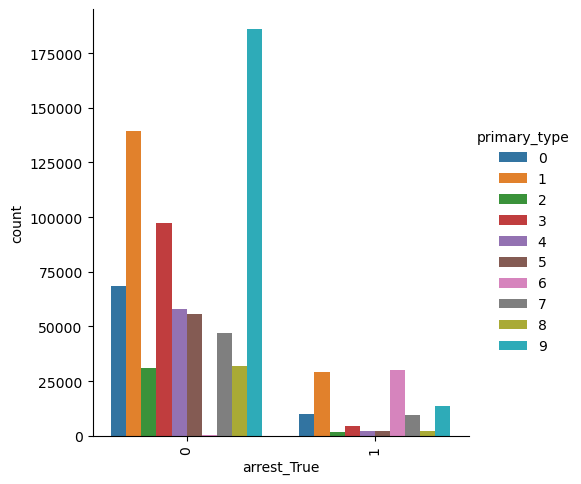

In [339]:
sns.catplot(x='arrest_True', hue='primary_type', kind='count', data=df_cleaned4)
plt.title('')
plt.xticks( rotation=90)
plt.show()

Narcotics show a very interest trend here . It likely results in arrests (Class 6) . As we see for arrest not true there is almost no data inside Narcotics.

#### How do crime rates and types vary across different seasons and days of the week?

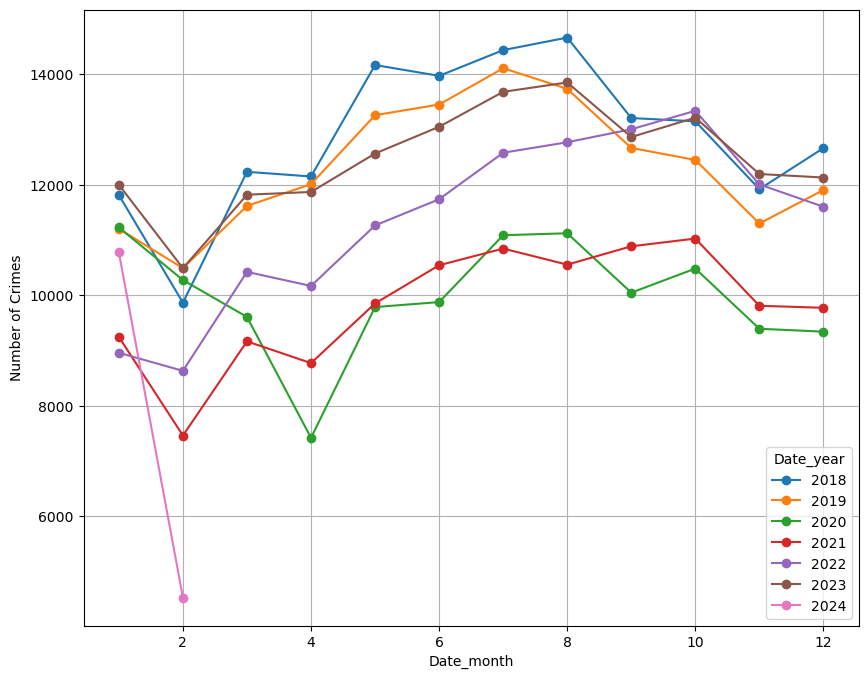

In [340]:
df.groupby(['Date_month','Date_year'])['unique_key'].count().unstack().plot(marker='o',figsize=(10,8))
plt.ylabel('Number of Crimes')
plt.grid()
plt.show()

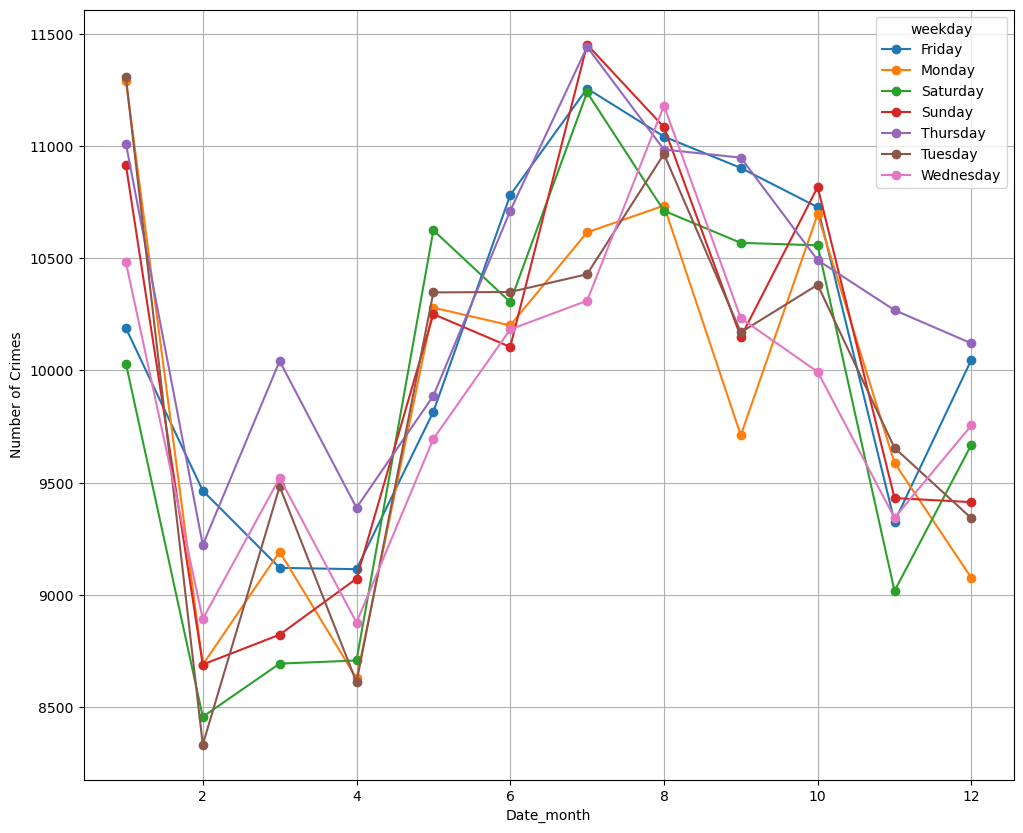

In [341]:
df.groupby(['Date_month','weekday'])['unique_key'].count().unstack().plot(marker='o',figsize=(12,10))
plt.ylabel('Number of Crimes')
plt.grid()
plt.show()

The crime data shows a potential weekend spike, with Thursdays and Fridays seeing higher numbers. This could be due to a combination of factors. More people might be out socializing, leading to increased opportunity for crimes. Businesses with weekend staff reductions could be easier targets. Finally, some reported crimes might be incidents that happened earlier but weren't reported until the weekend. The data reveals fluctuating crime rates across months (2018-2023), with potential seasonal trends. Summer months (June-August) might see a rise in crime due to increased social activity. Interestingly, 2020 stands out with a clear drop, especially early in the year. This likely aligns with lockdown measures taken during the COVID-19 pandemic.

#### Can a machine learning model accurately predict the primary type of crime (e.g., theft, assault) based on features like date, location description, community area, and day (derived from date)?


Our analysis identified XGBoostClassifier as the strongest performing model. It achieved the highest accuracy (0.6) and precision (0.68) on training set correctly classifying the most data points with minimal errors. This model also generalizes well, performing well on unseen data in the testing set.
.While XGBoostClassifier might take longer to train, its superior overall performance makes it the preferred choice for this project. 


## Conclusion

This research project successfully analyzed crime data in Chicago to gain valuable insights and inform crime prevention strategies. Here's a summary of the key findings:

- We explored how crime frequency varies across districts, identified hotspots for domestic-related crimes, and analyzed crime trends based on season and day of the week.
- Machine learning models were built and evaluated to predict the primary type of crime based on various features. 

Our analysis identified XGBoostClassifier as the strongest performing model. It achieved the highest accuracy (0.6) which was better than our **NULL error rate (0.24)** and precision (0.68) on training set correctly classifying the most data points with minimal errors. This model also generalizes well, performing well on unseen data in the testing set. It performs better than Random Forest Classifier on all metrics.


**Future Extensions:**

This project lays the groundwork for further exploration. Here are some potential extensions:


- Integrate real-time data feeds (e.g., weather, social media) to enhance crime prediction models.

- Include data on race and sex and other socio economic factors in the analysis to explore potential racial disparities in crime rates. 
- Move beyond basic prediction models and explore more sophisticated machine learning algorithms like deep learning models. These can potentially capture more complex relationships within the data and lead to more accurate crime predictions. However, careful evaluation and interpretability of these models would be essential.
- Utilize unsupervised learning techniques to uncover hidden patterns within the crime data. This could reveal previously unknown crime clusters or relationships between different crime types that could inform prevention strategies.